In [788]:
'''
2022.5.5
生脉注射液用药剂量预测模型：40、60
'''

'\n2022.5.5\n生脉注射液用药剂量预测模型：40、60\n'

In [789]:
import pandas as pd
import numpy as np

import sys
import re
import os
project_path = os.getcwd()

# 建模

## 读入数据

In [968]:
df_model =pd.read_excel(project_path +'/data/result/feature_engineering/df_3.5_model_data_forward.xlsx')
if 'Unnamed: 0' in df_model.columns:
    df_model = df_model.drop(['Unnamed: 0'], axis=1)

In [969]:
df_model.columns

Index(['日剂量', 'GGT_入院', '降脂药', '血红蛋白_入院', '前白蛋白_入院', '胆固醇_入院', '降血小板药'], dtype='object')

In [970]:
df_model.shape

(209, 7)

In [971]:
df_model['日剂量'].value_counts()

1    114
0     95
Name: 日剂量, dtype: int64

In [972]:
discrete_col=['降脂药','降血小板药']
continuous_col=[x for x in df_model.columns if x not in discrete_col]
continuous_col.remove('日剂量')

## 数据归一化

In [973]:
# 防止不同维特征数据差距过大，影响建模效果
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
# df_model[continuous_col]=ss.fit_transform(df_model[continuous_col])
for i in continuous_col:
    df_model[[i]] = ss.fit_transform(df_model[[i]])

In [974]:
df_model.columns

Index(['日剂量', 'GGT_入院', '降脂药', '血红蛋白_入院', '前白蛋白_入院', '胆固醇_入院', '降血小板药'], dtype='object')

In [975]:
df_model.to_excel(project_path+'/data/result/modeling/df_1.2_数据归一化.xlsx')

## 插补数据

In [976]:
# 使用随机森林对缺失值进行插补
import pandas as pd
pd.set_option('mode.chained_assignment', None)
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
def missing_value_interpolation(df):
    df = df.reset_index(drop=True)
    # 提取存在缺失值的列名
    missing_list = []
    for i in df.columns:
        if df[i].isnull().sum()>0:
            missing_list.append(i)
    missing_list_copy = missing_list.copy()
    # 用该列未缺失的值训练随机森林，然后用训练好的rf预测缺失值
    for i in range(len(missing_list)):
        name=missing_list[0]
        df_missing = df[missing_list_copy]
        # 将其他列的缺失值用0表示。
        missing_list.remove(name)
        for j in missing_list:
            df_missing[j]=df_missing[j].astype('str').apply(lambda x: 0 if x=='nan' else x)
        df_missing_is = df_missing[df_missing[name].isnull()]
        df_missing_not = df_missing[df_missing[name].notnull()]
        y = df_missing_not[name]
        x = df_missing_not.drop([name],axis=1)

        rfr = RandomForestRegressor(n_estimators=300,
                                    random_state=3)
        rfr.fit(x, y)
        #预测缺失值
        predict = rfr.predict(df_missing_is.drop([name],axis=1))
        #填补缺失值
        df.loc[df[name].isnull(),name] = predict
    return df

In [977]:
# 插补建模数据
df_model_cb=missing_value_interpolation(df_model)
# df_model_cb=df_model

In [978]:
df_model_cb.shape

(209, 7)

In [979]:
# 保存插补数据
df_model_cb.to_excel(project_path + '/data/result/modeling/df_1.3_model_data_插补.xlsx')

## 划分数据集

In [980]:
df_model_cb['日剂量'].value_counts()

1    114
0     95
Name: 日剂量, dtype: int64

### 计算随机数种子

In [991]:
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score,average_precision_score,precision_recall_curve
from sklearn.metrics import precision_score,recall_score,f1_score,roc_auc_score,accuracy_score

# 划分训练集和测试集，比例为8:2
x = df_model_cb.drop(['日剂量'],axis=1)
y = df_model_cb['日剂量']

seeds_list=[]
cat_f1_list=[]
for i in range(101):
    print(i)
    tran_x, test_x, tran_y, test_y = train_test_split(x, y, test_size=0.2, random_state=i)
    
    # 分类数据过采样
    from imblearn.over_sampling import SMOTE,ADASYN 
    sm = SMOTE(random_state=0)
    tran_x_sm,tran_y_sm = sm.fit_resample(tran_x,tran_y)
#     tran_x_sm,tran_y_sm=tran_x,tran_y
    
    import xgboost
    cat_model=xgboost.XGBClassifier(max_depth=5,
                        learning_rate=0.01,
                        n_estimators=500,
                        min_child_weight=0.5,
                        eta=0.1,
                        gamma=0.5,
                        reg_lambda=10,
                        subsample=0.5,
                        colsample_bytree=0.8,
                        nthread=4,
                        scale_pos_weight=1,
                        random_state=3)
    # 分类模型
    cat_model.fit(tran_x_sm,tran_y_sm)
    cat_predictions=cat_model.predict(test_x)
    cat_f1=f1_score(test_y,cat_predictions)
    # 防止分类数据的测试集划分不平衡
    if not (1.5>=(test_y.value_counts().values[0])/(test_y.value_counts().values[-1]) >=1):
        continue

#     import catboost
#     # CatBoost模型
#     cat_model=catboost.CatBoostRegressor(iterations=300, 
#                                           learning_rate=0.2, 
#                                           depth=6,
#                                           l2_leaf_reg=2,
#                                           subsample=1,
#                                           loss_function='RMSE', # 'CrossEntropy',
#                                           random_state=3)
#     # 回归模型
#     cat_model.fit(tran_x,tran_y)
#     cat_predictions=cat_model.predict(test_x)
#     cat_f1=r2_score(test_y,cat_predictions)
    
    seeds_list.append(i)
    cat_f1_list.append(cat_f1)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


In [992]:
df_seeds=pd.DataFrame(data={'seed':seeds_list,
                           'cat_f1':cat_f1_list})
df_seeds=df_seeds.sort_values(['cat_f1'], ascending=0).reset_index(drop=True)
df_seeds.to_excel(project_path+'/data/df_seeds.xlsx')

In [993]:
seed_index=df_seeds.loc[0,'seed']

In [994]:
seed_index

18

### 划分数据集

In [995]:
# 分类随机数种子
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
# 划分训练集和测试集，比例为8:2
x = df_model_cb.drop(['日剂量'],axis=1)
y = df_model_cb['日剂量']

seed_index=df_seeds.loc[0,'seed']
tran_x, test_x, tran_y, test_y = train_test_split(x, y, test_size=0.2, random_state=seed_index)

In [996]:
seed_index

18

In [997]:
df_model.shape

(209, 7)

In [998]:
print(tran_x.shape)
print(test_x.shape)

(167, 6)
(42, 6)


In [999]:
tran_y.value_counts()

1    90
0    77
Name: 日剂量, dtype: int64

In [1000]:
test_y.value_counts()

1    24
0    18
Name: 日剂量, dtype: int64

## 训练集过采样

In [1001]:
# 进行过采样
from imblearn.over_sampling import SMOTE,ADASYN 
from imblearn.combine import SMOTETomek
sm = SMOTE(random_state=0)
# sm=ADASYN(random_state=0)

tran_x_sm,tran_y_sm = sm.fit_resample(tran_x,tran_y)

In [1002]:
tran_x_sm.shape

(180, 6)

In [1003]:
tran_y_sm.value_counts()

1    90
0    90
Name: 日剂量, dtype: int64

In [1004]:
tran_x_sm.head()

,GGT_入院,降脂药,血红蛋白_入院,前白蛋白_入院,胆固醇_入院,降血小板药
0,-0.324429,1,0.067963,-0.333421,-0.298068,0
1,-0.355517,1,-0.238244,-0.005167,-0.210509,0
2,-0.292550,0,0.417913,-0.560288,-0.003549,0
3,-0.281113,0,0.242938,-0.354382,-0.344024,0
4,-0.315121,1,1.074070,1.712140,0.808369,1


In [1005]:
tran_x_sm.to_excel(project_path+'/data/tran_x_sm.xlsx')
tran_y_sm.to_excel(project_path+'/data/tran_y_sm.xlsx')

## 二分类模型

### 训练集+验证集：5-fold cross validation

In [1179]:
from sklearn.model_selection import KFold,StratifiedKFold 
from imblearn.over_sampling import SMOTE,ADASYN 
sm = SMOTE(random_state=0)

# 划分训练集和测试集，比例为8:2
x = tran_x
y = tran_y
# 五折交叉验证
kf = KFold(n_splits=5,random_state=seed_index,shuffle=True)

df_auc_accuracy=pd.DataFrame()
df_precision_f1=pd.DataFrame()
temp_importance_list=[]

for train_index, test_index in kf.split(x):

    tran_x_kf,test_x_kf,tran_y_kf,test_y_kf=x.values[train_index],x.values[test_index],y.values[train_index],y.values[test_index]
    
    from sklearn.metrics import r2_score,average_precision_score,precision_recall_curve,brier_score_loss
    from sklearn.metrics import precision_score,recall_score,f1_score,roc_auc_score,accuracy_score
    import xgboost
    # XGBoost模型
    xgb_model=xgboost.XGBClassifier(max_depth=5,
                            learning_rate=0.01,
                            n_estimators=500,
                            min_child_weight=0.5,
                            eta=0.1,
                            gamma=0.5,
                            reg_lambda=15,
                            subsample=0.5,
                            colsample_bytree=0.8,
                            nthread=4,
                            scale_pos_weight=1,
                            random_state=3)
    xgb_model.fit(tran_x_kf,tran_y_kf)


    import lightgbm
    # LightGBM模型
    lgbm_model=lightgbm.LGBMClassifier(iterations=300, 
                                      max_depth=4,
                                      min_child_weight=0.5,
                                      gamma=0.5,
                                       reg_lambda=5,
                                      subsample=0.8,
                                      learning_rate=0.02, 
                                      loss_function='CrossEntropy',
                                      random_state=3)
    lgbm_model.fit(tran_x_kf,tran_y_kf)

    import catboost
    # CatBoost模型
    cat_model=catboost.CatBoostClassifier(iterations=400, 
                                          learning_rate=0.008, 
                                          depth=8,
                                          l2_leaf_reg=2,
                                          loss_function='CrossEntropy',
                                          random_state=3)
    cat_model.fit(tran_x_kf,tran_y_kf)
    
    # 随机森林
    from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
    from sklearn.model_selection import GridSearchCV
    # 列出参数列表
    tree_grid_parameter = {'n_estimators': list((50, 100, 150, 200))}
    # 进行参数的搜索组合
    grid = GridSearchCV(RandomForestClassifier(), param_grid=tree_grid_parameter, cv=3)
    # 根据已有数据去拟合随机森林模型
#     grid.fit(tran_x_sm, tran_y_sm)
    rf_model = RandomForestClassifier(n_estimators=50,  #grid.best_params_['n_estimators'],
                                max_depth=1,
                                random_state=3)
    rf_model.fit(tran_x_kf, tran_y_kf)

    # GBDT
    # 列出参数列表
    gbdt_model = GradientBoostingClassifier(n_estimators=300,
                                learning_rate=0.1,
                                max_depth=8,
                                subsample=0.4,
                                random_state=3)
    gbdt_model.fit(tran_x_kf,tran_y_kf)
    # 预测缺失值


    # SVR
    from sklearn.svm import SVR,SVC
    # 回归模型
    # svr = SVR(kernel='linear', C=1.25)
    # 分类模型
    svr_model = SVC(kernel='rbf',
                    C=50,
                    cache_size=200,
                    probability=True,
                    random_state=3)
    svr_model.fit(tran_x_kf,tran_y_kf)


    # Linear回归，Lasso回归，领回归，logistic回归
    from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNet,LogisticRegression
    lcv_model = LogisticRegression(penalty='l2',
                             C=50,
                            solver='newton-cg',
                             max_iter=20,
                            random_state=3)
    # lcv = Lasso()
    # lcv = Ridge()
    lcv_model.fit(tran_x_kf, tran_y_kf)

    # ANN
    from sklearn.neural_network import MLPClassifier
    from sklearn.metrics import classification_report,confusion_matrix

    ANN_model = MLPClassifier(alpha=0.1, 
                        hidden_layer_sizes=[100,], 
                        solver='adam', 
                        activation='relu', 
                        random_state=3)
    ANN_model.fit(tran_x_kf, tran_y_kf)


    # TabNet
    import torch
    from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
    from pytorch_tabnet.multitask import TabNetMultiTaskClassifier
    TabNet_model = TabNetClassifier(
                            n_d=3,
                            n_a=3,
                            n_steps=5,
                            gamma=1,)
#                            optimizer_fn=torch.optim.Adam,
#                            optimizer_params=dict(lr=2e-2),
#                            scheduler_params={"step_size":50, # how to use learning rate scheduler
#                                              "gamma":0.9},
#                            scheduler_fn=torch.optim.lr_scheduler.StepLR,
#                            mask_type='entmax') # "sparsemax"
    tran_x_kf_x, tran_x_kf_valid, tran_y_kf_y, tran_y_kf_valid = train_test_split(tran_x_kf, tran_y_kf, test_size=0.125, random_state=3)

    TabNet_model.fit(X_train=tran_x_kf, 
            y_train=tran_y_kf,
#             eval_set=[(tran_x_kf_valid,tran_y_kf_valid)],
            max_epochs=200, 
            patience=50,
            batch_size=64, 
            virtual_batch_size=16,
            num_workers=0,
            drop_last=False)
#             loss_fn=[torch.nn.functional.cross_entropy]) # Optional, just an example of list usage

    # 计算评价指标compute evaluation metrics
    from sklearn.metrics import classification_report,confusion_matrix
    # 统一模型输出结果
#     df_model_result=pd.DataFrame(
#         columns=['model','index','precision','recall','f1-score','support','accuracy','AUC','sensitivity','specificity'])

    model_list=[xgb_model,lgbm_model,cat_model,rf_model,gbdt_model,svr_model,lcv_model,ANN_model,TabNet_model]
    model_name_list=['XGBoost','LGBM','CatBoost','RF','GBDT','SVR','LR','ANN','TabNet']
#     model_list=[cat_model]
#     model_name_list=['CatBoost']

    temp_auc=pd.DataFrame(
        columns=['model','precision','recall','f1','accuracy','AUC'])    
    for model,name in zip(model_list,model_name_list):
        print(name)
        # 计算accuracy和AUC
        # tabnet predict_proba结果是三维数组，无法计算auc，需要reshape(-1,6),所有行 x 6列
        test_y_score=model.predict_proba(test_x_kf)[:,1]
        auc=roc_auc_score(test_y_kf,test_y_score)
        auc=round(auc,2)
        # tabnet predict结果是三维数组，无法计算auc，需要reshape
        accuracy=accuracy_score(test_y_kf,model.predict(test_x_kf))
        accuracy=round(accuracy,2)
        # 计算precision、recall、F1
        predictions=model.predict(test_x_kf)
        precision=precision_score(test_y_kf,predictions)
        precision=round(precision,2)
        recall=recall_score(test_y_kf,predictions)
        recall=round(recall,2)
        f1=f1_score(test_y_kf,predictions)
        f1=round(f1,2)
        
        temp_auc.loc[temp_auc.shape[0],['model','precision','recall','f1','accuracy','AUC']]=\
                                                                    [name,precision,recall,f1,accuracy,auc]
    df_auc_accuracy=pd.concat([df_auc_accuracy,temp_auc],axis=0)
                                       
    # 变量重要性评分
    importance = xgb_model.feature_importances_
    df_importance_temp=pd.DataFrame(data={'特征':x.columns,'重要性评分':importance})
    temp_importance_list.append(df_importance_temp)

0:	learn: 0.6882329	total: 1.91ms	remaining: 763ms
1:	learn: 0.6831575	total: 3.62ms	remaining: 721ms
2:	learn: 0.6797974	total: 4.47ms	remaining: 592ms
3:	learn: 0.6762791	total: 6.26ms	remaining: 619ms
4:	learn: 0.6735354	total: 8.07ms	remaining: 637ms
5:	learn: 0.6683618	total: 9.91ms	remaining: 651ms
6:	learn: 0.6638480	total: 11.6ms	remaining: 649ms
7:	learn: 0.6593440	total: 13.2ms	remaining: 649ms
8:	learn: 0.6557808	total: 15.1ms	remaining: 657ms
9:	learn: 0.6509273	total: 17.2ms	remaining: 671ms
10:	learn: 0.6456003	total: 19.2ms	remaining: 678ms
11:	learn: 0.6415423	total: 20.7ms	remaining: 671ms
12:	learn: 0.6369827	total: 22.4ms	remaining: 667ms
13:	learn: 0.6343883	total: 22.9ms	remaining: 633ms
14:	learn: 0.6302269	total: 24.6ms	remaining: 633ms
15:	learn: 0.6261489	total: 26.4ms	remaining: 633ms
16:	learn: 0.6216651	total: 27.9ms	remaining: 629ms
17:	learn: 0.6175458	total: 29.5ms	remaining: 627ms
18:	learn: 0.6132459	total: 31.2ms	remaining: 627ms
19:	learn: 0.6115076	t

220:	learn: 0.2656352	total: 320ms	remaining: 259ms
221:	learn: 0.2647902	total: 321ms	remaining: 258ms
222:	learn: 0.2638870	total: 323ms	remaining: 256ms
223:	learn: 0.2629672	total: 324ms	remaining: 255ms
224:	learn: 0.2621087	total: 326ms	remaining: 253ms
225:	learn: 0.2613732	total: 327ms	remaining: 252ms
226:	learn: 0.2601097	total: 328ms	remaining: 250ms
227:	learn: 0.2590243	total: 330ms	remaining: 249ms
228:	learn: 0.2583193	total: 331ms	remaining: 247ms
229:	learn: 0.2573323	total: 333ms	remaining: 246ms
230:	learn: 0.2566603	total: 335ms	remaining: 245ms
231:	learn: 0.2559254	total: 336ms	remaining: 244ms
232:	learn: 0.2552026	total: 338ms	remaining: 242ms
233:	learn: 0.2545323	total: 339ms	remaining: 241ms
234:	learn: 0.2538153	total: 341ms	remaining: 239ms
235:	learn: 0.2532844	total: 342ms	remaining: 238ms
236:	learn: 0.2522781	total: 343ms	remaining: 236ms
237:	learn: 0.2514959	total: 345ms	remaining: 235ms
238:	learn: 0.2504796	total: 346ms	remaining: 233ms
239:	learn: 

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


Device used : cpu
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 0.77709 |  0:00:00s
epoch 1  | loss: 0.68911 |  0:00:00s
epoch 2  | loss: 0.74495 |  0:00:00s
epoch 3  | loss: 0.71731 |  0:00:00s
epoch 4  | loss: 0.68604 |  0:00:00s
epoch 5  | loss: 0.67727 |  0:00:00s
epoch 6  | loss: 0.68615 |  0:00:00s
epoch 7  | loss: 0.69152 |  0:00:00s
epoch 8  | loss: 0.69894 |  0:00:00s
epoch 9  | loss: 0.64098 |  0:00:00s
epoch 10 | loss: 0.6487  |  0:00:00s
epoch 11 | loss: 0.61917 |  0:00:01s
epoch 12 | loss: 0.63305 |  0:00:01s
epoch 13 | loss: 0.59645 |  0:00:01s
epoch 14 | loss: 0.61062 |  0:00:01s
epoch 15 | loss: 0.60866 |  0:00:01s
epoch 16 | loss: 0.59741 |  0:00:01s
epoch 17 | loss: 0.59729 |  0:00:01s
epoch 18 | loss: 0.61433 |  0:00:01s
epoch 19 | loss: 0.61442 |  0:00:01s
epoch 20 | loss: 0.61887 |  0:00:01s
epoch 21 | loss: 0.55633 |  0:00:01s
epoch 22 | loss: 0.58832 |  0:00:02s
epoch 23 | loss: 0.603   |  0:00:02s
epoch 24 | loss: 0.55

105:	learn: 0.4159768	total: 161ms	remaining: 446ms
106:	learn: 0.4147223	total: 162ms	remaining: 444ms
107:	learn: 0.4134338	total: 164ms	remaining: 443ms
108:	learn: 0.4119453	total: 165ms	remaining: 441ms
109:	learn: 0.4106215	total: 167ms	remaining: 439ms
110:	learn: 0.4098075	total: 167ms	remaining: 435ms
111:	learn: 0.4079998	total: 169ms	remaining: 434ms
112:	learn: 0.4063382	total: 170ms	remaining: 433ms
113:	learn: 0.4045260	total: 172ms	remaining: 431ms
114:	learn: 0.4028570	total: 173ms	remaining: 430ms
115:	learn: 0.4017335	total: 175ms	remaining: 428ms
116:	learn: 0.3996296	total: 176ms	remaining: 427ms
117:	learn: 0.3980586	total: 178ms	remaining: 425ms
118:	learn: 0.3962266	total: 179ms	remaining: 424ms
119:	learn: 0.3946453	total: 181ms	remaining: 422ms
120:	learn: 0.3936631	total: 183ms	remaining: 423ms
121:	learn: 0.3921596	total: 185ms	remaining: 421ms
122:	learn: 0.3908270	total: 186ms	remaining: 420ms
123:	learn: 0.3898222	total: 188ms	remaining: 418ms
124:	learn: 

334:	learn: 0.2143108	total: 486ms	remaining: 94.4ms
335:	learn: 0.2138931	total: 488ms	remaining: 93ms
336:	learn: 0.2132985	total: 490ms	remaining: 91.5ms
337:	learn: 0.2130650	total: 491ms	remaining: 90.1ms
338:	learn: 0.2126714	total: 492ms	remaining: 88.6ms
339:	learn: 0.2123980	total: 494ms	remaining: 87.1ms
340:	learn: 0.2119944	total: 495ms	remaining: 85.7ms
341:	learn: 0.2114976	total: 497ms	remaining: 84.2ms
342:	learn: 0.2109279	total: 498ms	remaining: 82.8ms
343:	learn: 0.2106329	total: 500ms	remaining: 81.3ms
344:	learn: 0.2101603	total: 501ms	remaining: 79.9ms
345:	learn: 0.2096277	total: 503ms	remaining: 78.5ms
346:	learn: 0.2093497	total: 504ms	remaining: 77ms
347:	learn: 0.2088656	total: 506ms	remaining: 75.6ms
348:	learn: 0.2084391	total: 507ms	remaining: 74.2ms
349:	learn: 0.2077049	total: 509ms	remaining: 72.7ms
350:	learn: 0.2069688	total: 511ms	remaining: 71.3ms
351:	learn: 0.2063931	total: 512ms	remaining: 69.8ms
352:	learn: 0.2058523	total: 514ms	remaining: 68.4

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


Device used : cpu
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 0.70541 |  0:00:00s
epoch 1  | loss: 0.71192 |  0:00:00s
epoch 2  | loss: 0.72129 |  0:00:00s
epoch 3  | loss: 0.71032 |  0:00:00s
epoch 4  | loss: 0.6837  |  0:00:00s
epoch 5  | loss: 0.64913 |  0:00:00s
epoch 6  | loss: 0.66305 |  0:00:00s
epoch 7  | loss: 0.66089 |  0:00:00s
epoch 8  | loss: 0.68217 |  0:00:00s
epoch 9  | loss: 0.67714 |  0:00:00s
epoch 10 | loss: 0.67417 |  0:00:00s
epoch 11 | loss: 0.68651 |  0:00:01s
epoch 12 | loss: 0.66421 |  0:00:01s
epoch 13 | loss: 0.60998 |  0:00:01s
epoch 14 | loss: 0.65482 |  0:00:01s
epoch 15 | loss: 0.62805 |  0:00:01s
epoch 16 | loss: 0.65664 |  0:00:01s
epoch 17 | loss: 0.7121  |  0:00:01s
epoch 18 | loss: 0.64913 |  0:00:01s
epoch 19 | loss: 0.6632  |  0:00:01s
epoch 20 | loss: 0.65193 |  0:00:01s
epoch 21 | loss: 0.61415 |  0:00:02s
epoch 22 | loss: 0.63349 |  0:00:02s
epoch 23 | loss: 0.63739 |  0:00:02s
epoch 24 | loss: 0.59

100:	learn: 0.4295051	total: 158ms	remaining: 466ms
101:	learn: 0.4278130	total: 159ms	remaining: 465ms
102:	learn: 0.4259423	total: 161ms	remaining: 465ms
103:	learn: 0.4245540	total: 163ms	remaining: 463ms
104:	learn: 0.4228228	total: 164ms	remaining: 461ms
105:	learn: 0.4213395	total: 166ms	remaining: 459ms
106:	learn: 0.4193592	total: 167ms	remaining: 458ms
107:	learn: 0.4185024	total: 169ms	remaining: 456ms
108:	learn: 0.4166094	total: 170ms	remaining: 454ms
109:	learn: 0.4154952	total: 172ms	remaining: 452ms
110:	learn: 0.4135568	total: 173ms	remaining: 451ms
111:	learn: 0.4115107	total: 175ms	remaining: 451ms
112:	learn: 0.4101071	total: 177ms	remaining: 449ms
113:	learn: 0.4089871	total: 178ms	remaining: 446ms
114:	learn: 0.4089057	total: 178ms	remaining: 441ms
115:	learn: 0.4075212	total: 180ms	remaining: 440ms
116:	learn: 0.4061827	total: 181ms	remaining: 438ms
117:	learn: 0.4047526	total: 182ms	remaining: 436ms
118:	learn: 0.4036622	total: 184ms	remaining: 434ms
119:	learn: 

337:	learn: 0.2285142	total: 483ms	remaining: 88.6ms
338:	learn: 0.2279388	total: 485ms	remaining: 87.2ms
339:	learn: 0.2274291	total: 486ms	remaining: 85.8ms
340:	learn: 0.2266336	total: 487ms	remaining: 84.3ms
341:	learn: 0.2259267	total: 489ms	remaining: 82.9ms
342:	learn: 0.2252496	total: 490ms	remaining: 81.5ms
343:	learn: 0.2249352	total: 492ms	remaining: 80.1ms
344:	learn: 0.2244248	total: 493ms	remaining: 78.6ms
345:	learn: 0.2243482	total: 494ms	remaining: 77.1ms
346:	learn: 0.2237051	total: 495ms	remaining: 75.7ms
347:	learn: 0.2231539	total: 497ms	remaining: 74.2ms
348:	learn: 0.2226232	total: 498ms	remaining: 72.8ms
349:	learn: 0.2221979	total: 500ms	remaining: 71.4ms
350:	learn: 0.2217881	total: 501ms	remaining: 70ms
351:	learn: 0.2215986	total: 502ms	remaining: 68.5ms
352:	learn: 0.2209540	total: 504ms	remaining: 67.1ms
353:	learn: 0.2205233	total: 505ms	remaining: 65.6ms
354:	learn: 0.2199729	total: 507ms	remaining: 64.2ms
355:	learn: 0.2192324	total: 508ms	remaining: 62

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


Device used : cpu
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 0.7478  |  0:00:00s
epoch 1  | loss: 0.70795 |  0:00:00s
epoch 2  | loss: 0.66165 |  0:00:00s
epoch 3  | loss: 0.60443 |  0:00:00s
epoch 4  | loss: 0.64304 |  0:00:00s
epoch 5  | loss: 0.63153 |  0:00:00s
epoch 6  | loss: 0.64203 |  0:00:00s
epoch 7  | loss: 0.63595 |  0:00:00s
epoch 8  | loss: 0.63408 |  0:00:00s
epoch 9  | loss: 0.61746 |  0:00:00s
epoch 10 | loss: 0.71757 |  0:00:00s
epoch 11 | loss: 0.66318 |  0:00:01s
epoch 12 | loss: 0.59925 |  0:00:01s
epoch 13 | loss: 0.62712 |  0:00:01s
epoch 14 | loss: 0.63054 |  0:00:01s
epoch 15 | loss: 0.63038 |  0:00:01s
epoch 16 | loss: 0.68585 |  0:00:01s
epoch 17 | loss: 0.61536 |  0:00:01s
epoch 18 | loss: 0.62971 |  0:00:01s
epoch 19 | loss: 0.59127 |  0:00:01s
epoch 20 | loss: 0.57752 |  0:00:01s
epoch 21 | loss: 0.5829  |  0:00:01s
epoch 22 | loss: 0.62428 |  0:00:02s
epoch 23 | loss: 0.63016 |  0:00:02s
epoch 24 | loss: 0.59

116:	learn: 0.4093338	total: 163ms	remaining: 395ms
117:	learn: 0.4074362	total: 165ms	remaining: 394ms
118:	learn: 0.4062916	total: 166ms	remaining: 392ms
119:	learn: 0.4045066	total: 168ms	remaining: 391ms
120:	learn: 0.4032074	total: 169ms	remaining: 390ms
121:	learn: 0.4017597	total: 170ms	remaining: 388ms
122:	learn: 0.3997623	total: 172ms	remaining: 387ms
123:	learn: 0.3985247	total: 173ms	remaining: 385ms
124:	learn: 0.3970042	total: 174ms	remaining: 384ms
125:	learn: 0.3963540	total: 176ms	remaining: 382ms
126:	learn: 0.3946464	total: 178ms	remaining: 382ms
127:	learn: 0.3934455	total: 179ms	remaining: 380ms
128:	learn: 0.3917111	total: 180ms	remaining: 379ms
129:	learn: 0.3902323	total: 182ms	remaining: 378ms
130:	learn: 0.3898395	total: 182ms	remaining: 375ms
131:	learn: 0.3884738	total: 184ms	remaining: 373ms
132:	learn: 0.3877346	total: 185ms	remaining: 372ms
133:	learn: 0.3866182	total: 187ms	remaining: 371ms
134:	learn: 0.3855505	total: 188ms	remaining: 369ms
135:	learn: 

352:	learn: 0.2062455	total: 490ms	remaining: 65.2ms
353:	learn: 0.2058979	total: 492ms	remaining: 63.9ms
354:	learn: 0.2051947	total: 493ms	remaining: 62.5ms
355:	learn: 0.2045481	total: 494ms	remaining: 61.1ms
356:	learn: 0.2039013	total: 496ms	remaining: 59.7ms
357:	learn: 0.2032268	total: 497ms	remaining: 58.3ms
358:	learn: 0.2029257	total: 498ms	remaining: 56.9ms
359:	learn: 0.2023315	total: 499ms	remaining: 55.5ms
360:	learn: 0.2019395	total: 501ms	remaining: 54.1ms
361:	learn: 0.2014666	total: 502ms	remaining: 52.7ms
362:	learn: 0.2011790	total: 503ms	remaining: 51.3ms
363:	learn: 0.2007278	total: 504ms	remaining: 49.9ms
364:	learn: 0.2002243	total: 506ms	remaining: 48.5ms
365:	learn: 0.2001677	total: 506ms	remaining: 47ms
366:	learn: 0.1995819	total: 508ms	remaining: 45.6ms
367:	learn: 0.1993840	total: 509ms	remaining: 44.2ms
368:	learn: 0.1991884	total: 510ms	remaining: 42.8ms
369:	learn: 0.1985770	total: 511ms	remaining: 41.5ms
370:	learn: 0.1982303	total: 513ms	remaining: 40

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


Device used : cpu
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 0.76008 |  0:00:00s
epoch 1  | loss: 0.74452 |  0:00:00s
epoch 2  | loss: 0.70039 |  0:00:00s
epoch 3  | loss: 0.7112  |  0:00:00s
epoch 4  | loss: 0.78171 |  0:00:00s
epoch 5  | loss: 0.74847 |  0:00:00s
epoch 6  | loss: 0.71375 |  0:00:00s
epoch 7  | loss: 0.69521 |  0:00:00s
epoch 8  | loss: 0.72554 |  0:00:00s
epoch 9  | loss: 0.65285 |  0:00:00s
epoch 10 | loss: 0.63741 |  0:00:00s
epoch 11 | loss: 0.63572 |  0:00:01s
epoch 12 | loss: 0.65094 |  0:00:01s
epoch 13 | loss: 0.6405  |  0:00:01s
epoch 14 | loss: 0.65193 |  0:00:01s
epoch 15 | loss: 0.64325 |  0:00:01s
epoch 16 | loss: 0.60615 |  0:00:01s
epoch 17 | loss: 0.65699 |  0:00:01s
epoch 18 | loss: 0.63387 |  0:00:01s
epoch 19 | loss: 0.60878 |  0:00:01s
epoch 20 | loss: 0.60882 |  0:00:01s
epoch 21 | loss: 0.59925 |  0:00:01s
epoch 22 | loss: 0.60467 |  0:00:02s
epoch 23 | loss: 0.65402 |  0:00:02s
epoch 24 | loss: 0.58

102:	learn: 0.4208829	total: 155ms	remaining: 447ms
103:	learn: 0.4192670	total: 157ms	remaining: 446ms
104:	learn: 0.4180075	total: 158ms	remaining: 444ms
105:	learn: 0.4164159	total: 160ms	remaining: 443ms
106:	learn: 0.4144130	total: 161ms	remaining: 441ms
107:	learn: 0.4124801	total: 163ms	remaining: 439ms
108:	learn: 0.4108040	total: 164ms	remaining: 438ms
109:	learn: 0.4090665	total: 165ms	remaining: 436ms
110:	learn: 0.4073763	total: 167ms	remaining: 435ms
111:	learn: 0.4062502	total: 168ms	remaining: 433ms
112:	learn: 0.4048512	total: 170ms	remaining: 432ms
113:	learn: 0.4030010	total: 171ms	remaining: 430ms
114:	learn: 0.4018020	total: 173ms	remaining: 429ms
115:	learn: 0.4002093	total: 174ms	remaining: 427ms
116:	learn: 0.3989360	total: 176ms	remaining: 425ms
117:	learn: 0.3973051	total: 177ms	remaining: 424ms
118:	learn: 0.3962183	total: 179ms	remaining: 422ms
119:	learn: 0.3944681	total: 180ms	remaining: 420ms
120:	learn: 0.3926524	total: 182ms	remaining: 419ms
121:	learn: 

337:	learn: 0.2026782	total: 483ms	remaining: 88.5ms
338:	learn: 0.2021937	total: 484ms	remaining: 87.1ms
339:	learn: 0.2018361	total: 486ms	remaining: 85.7ms
340:	learn: 0.2014716	total: 487ms	remaining: 84.3ms
341:	learn: 0.2013828	total: 488ms	remaining: 82.7ms
342:	learn: 0.2007702	total: 489ms	remaining: 81.3ms
343:	learn: 0.2003506	total: 491ms	remaining: 79.9ms
344:	learn: 0.1998589	total: 492ms	remaining: 78.5ms
345:	learn: 0.1992938	total: 494ms	remaining: 77ms
346:	learn: 0.1987826	total: 495ms	remaining: 75.6ms
347:	learn: 0.1984584	total: 496ms	remaining: 74.1ms
348:	learn: 0.1976370	total: 498ms	remaining: 72.7ms
349:	learn: 0.1973109	total: 499ms	remaining: 71.3ms
350:	learn: 0.1967051	total: 500ms	remaining: 69.9ms
351:	learn: 0.1960673	total: 502ms	remaining: 68.4ms
352:	learn: 0.1954008	total: 503ms	remaining: 67ms
353:	learn: 0.1948649	total: 505ms	remaining: 65.6ms
354:	learn: 0.1942021	total: 506ms	remaining: 64.2ms
355:	learn: 0.1935644	total: 508ms	remaining: 62.8

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


Device used : cpu
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 0.81498 |  0:00:00s
epoch 1  | loss: 0.71852 |  0:00:00s
epoch 2  | loss: 0.7073  |  0:00:00s
epoch 3  | loss: 0.6476  |  0:00:00s
epoch 4  | loss: 0.65012 |  0:00:00s
epoch 5  | loss: 0.64518 |  0:00:00s
epoch 6  | loss: 0.68892 |  0:00:00s
epoch 7  | loss: 0.66567 |  0:00:00s
epoch 8  | loss: 0.66412 |  0:00:00s
epoch 9  | loss: 0.63533 |  0:00:00s
epoch 10 | loss: 0.66913 |  0:00:00s
epoch 11 | loss: 0.64654 |  0:00:01s
epoch 12 | loss: 0.60233 |  0:00:01s
epoch 13 | loss: 0.6193  |  0:00:01s
epoch 14 | loss: 0.63438 |  0:00:01s
epoch 15 | loss: 0.6181  |  0:00:01s
epoch 16 | loss: 0.64925 |  0:00:01s
epoch 17 | loss: 0.66062 |  0:00:01s
epoch 18 | loss: 0.62787 |  0:00:01s
epoch 19 | loss: 0.59573 |  0:00:01s
epoch 20 | loss: 0.61741 |  0:00:01s
epoch 21 | loss: 0.63339 |  0:00:01s
epoch 22 | loss: 0.58019 |  0:00:02s
epoch 23 | loss: 0.6516  |  0:00:02s
epoch 24 | loss: 0.59

In [1180]:
df_auc_accuracy

,model,precision,recall,f1,accuracy,AUC
0,XGBoost,0.57,0.8,0.67,0.65,0.7
1,LGBM,0.5,0.67,0.57,0.56,0.65
2,CatBoost,0.53,0.67,0.59,0.59,0.61
3,RF,0.5,0.8,0.62,0.56,0.71
4,GBDT,0.61,0.73,0.67,0.68,0.69
5,SVR,0.37,0.47,0.41,0.41,0.41
6,LR,0.54,0.87,0.67,0.62,0.74
7,ANN,0.5,0.73,0.59,0.56,0.71
8,TabNet,0.55,0.8,0.65,0.62,0.66
0,XGBoost,0.55,0.61,0.58,0.53,0.62


In [1181]:
df_auc_accuracy.dtypes

model        object
precision    object
recall       object
f1           object
accuracy     object
AUC          object
dtype: object

In [1182]:
df_auc_accuracy['precision']=df_auc_accuracy['precision'].astype('float')
df_auc_accuracy['recall']=df_auc_accuracy['recall'].astype('float')
df_auc_accuracy['f1']=df_auc_accuracy['f1'].astype('float')
df_auc_accuracy['accuracy']=df_auc_accuracy['accuracy'].astype('float')
df_auc_accuracy['AUC']=df_auc_accuracy['AUC'].astype('float')

In [1183]:
df_model_result=df_auc_accuracy.groupby(['model'])[['precision','recall','f1','accuracy','AUC']].mean().reset_index()
df_model_result=df_model_result.round(2)

In [1184]:
df_model_result

,model,precision,recall,f1,accuracy,AUC
0,ANN,0.71,0.70,0.69,0.67,0.69
1,CatBoost,0.67,0.71,0.68,0.66,0.69
2,GBDT,0.64,0.66,0.64,0.61,0.65
3,LGBM,0.64,0.68,0.65,0.63,0.69
4,LR,0.68,0.74,0.70,0.67,0.74
5,RF,0.64,0.71,0.66,0.62,0.73
6,SVR,0.58,0.57,0.56,0.53,0.56
7,TabNet,0.71,0.70,0.69,0.67,0.66
8,XGBoost,0.67,0.70,0.68,0.65,0.70


In [1185]:
# 排序
df_model_result['temp_num']=[8,3,5,2,6,4,7,9,1]
df_model_result=df_model_result.sort_values(by=['temp_num'],ascending=True).drop(['temp_num'],axis=1)

In [1186]:
df_model_result

,model,precision,recall,f1,accuracy,AUC
8,XGBoost,0.67,0.70,0.68,0.65,0.70
3,LGBM,0.64,0.68,0.65,0.63,0.69
1,CatBoost,0.67,0.71,0.68,0.66,0.69
5,RF,0.64,0.71,0.66,0.62,0.73
2,GBDT,0.64,0.66,0.64,0.61,0.65
4,LR,0.68,0.74,0.70,0.67,0.74
6,SVR,0.58,0.57,0.56,0.53,0.56
0,ANN,0.71,0.70,0.69,0.67,0.69
7,TabNet,0.71,0.70,0.69,0.67,0.66


In [1187]:
df_importance=pd.concat(temp_importance_list,axis=0)
del temp_importance_list

In [1188]:
df_importance

,特征,重要性评分
0,GGT_入院,0.155417
1,降脂药,0.147675
2,血红蛋白_入院,0.196579
3,前白蛋白_入院,0.198128
4,胆固醇_入院,0.146021
5,降血小板药,0.156179
0,GGT_入院,0.132922
1,降脂药,0.129014
2,血红蛋白_入院,0.196552
3,前白蛋白_入院,0.175131


In [1189]:
df_importance=df_importance.groupby(['特征'])[['重要性评分']].mean().sort_values(['重要性评分'],ascending=False).reset_index()
df_importance=df_importance.round(3)

In [1190]:
df_importance

,特征,重要性评分
0,血红蛋白_入院,0.203
1,胆固醇_入院,0.189
2,前白蛋白_入院,0.168
3,降血小板药,0.152
4,降脂药,0.146
5,GGT_入院,0.141


In [1191]:
df_importance.to_excel(project_path+'/data/result/modeling/df_1.6.1_模型重要性评分.xlsx')

### 测试集

In [1192]:
test_x.columns

Index(['f0', 'f1', 'f2', 'f3', 'f4', 'f5'], dtype='object')

In [1193]:
# 调整test_x变量名
test_x.columns=['f0', 'f1', 'f2', 'f3', 'f4', 'f5']

In [1194]:
test_y.value_counts()

1    24
0    18
Name: 日剂量, dtype: int64

In [1199]:
# 计算评价指标compute evaluation metrics
from sklearn.metrics import classification_report,confusion_matrix
# 统一模型输出结果
df_model_result=pd.DataFrame(columns=['model','precision','recall','f1','accuracy','AUC'])

model_list=[xgb_model,lgbm_model,cat_model,rf_model,gbdt_model,svr_model,lcv_model,ANN_model,TabNet_model]
model_name_list=['XGBoost','LGBM','CatBoost','RF','GBDT','SVR','LR','ANN','TabNet']
# model_list=[xgb_model,lgbm_model,cat_model]
# model_name_list=['XGBoost','LGBM','CatBoost']

for model,name in zip(model_list,model_name_list):
    print(name)
    # 计算accuracy和AUC
    # tabnet predict_proba结果是三维数组，无法计算auc，需要reshape(-1,6),所有行 x 6列
    if name == 'TabNet':
        test_temp=test_x
        test_x=test_temp.to_numpy()
    test_y_score=model.predict_proba(test_x)[:,1]
    auc=roc_auc_score(test_y,test_y_score)
    auc=round(auc,2)
    # tabnet predict结果是三维数组，无法计算auc，需要reshape
    accuracy=accuracy_score(test_y,model.predict(test_x))
    accuracy=round(accuracy,2)
    # 计算precision、recall、F1
    predictions=model.predict(test_x)
    precision=precision_score(test_y,predictions)
    precision=round(precision,2)
    recall=recall_score(test_y,predictions)
    recall=round(recall,2)
    f1=f1_score(test_y,predictions)
    f1=round(f1,2)
    if name == 'TabNet':
        test_x=test_temp
        
    df_model_result.loc[df_model_result.shape[0],['model','precision','recall','f1','accuracy','AUC']]=\
                                                                [name,precision,recall,f1,accuracy,auc]

XGBoost
LGBM
CatBoost
RF
GBDT
SVR
LR
ANN
TabNet


In [1200]:
cm2_LogR_model = confusion_matrix(test_y, xgb_model.predict(test_x))
print(cm2_LogR_model) #混肴矩阵
print(classification_report(test_y, xgb_model.predict(test_x)))

[[17  1]
 [ 6 18]]
              precision    recall  f1-score   support

           0       0.74      0.94      0.83        18
           1       0.95      0.75      0.84        24

    accuracy                           0.83        42
   macro avg       0.84      0.85      0.83        42
weighted avg       0.86      0.83      0.83        42



In [1201]:
df_model_result

,model,precision,recall,f1,accuracy,AUC
0,XGBoost,0.95,0.75,0.84,0.83,0.9
1,LGBM,0.94,0.71,0.81,0.81,0.88
2,CatBoost,0.89,0.71,0.79,0.79,0.84
3,RF,0.94,0.62,0.75,0.76,0.86
4,GBDT,0.81,0.71,0.76,0.74,0.85
5,SVR,0.75,0.75,0.75,0.71,0.71
6,LR,0.81,0.71,0.76,0.74,0.84
7,ANN,0.81,0.71,0.76,0.74,0.83
8,TabNet,0.8,0.67,0.73,0.71,0.79


In [1202]:
df_model.columns

Index(['日剂量', 'GGT_入院', '降脂药', '血红蛋白_入院', '前白蛋白_入院', '胆固醇_入院', '降血小板药'], dtype='object')

In [1203]:
# 保存模型测试效果
df_model_result.to_excel(project_path+'/data/result/modeling/df_1.6.2_二分类_模型测试效果.xlsx')

## 多分类模型

In [168]:
# 分类随机数种子
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
# 划分训练集和测试集，比例为8:2
x = df_model_cb.drop(['日剂量'],axis=1)
y = df_model_cb['日剂量']

seed_index=df_seeds.loc[0,'seed']
tran_x, test_x, tran_y, test_y = train_test_split(x, y, test_size=0.2, random_state=0)

In [170]:
tran_x_sm=tran_x.copy()
tran_y_sm=tran_y.copy()

### 未插补模型

In [171]:
from sklearn.metrics import r2_score,average_precision_score,precision_recall_curve
from sklearn.metrics import precision_score,recall_score,f1_score,roc_auc_score,accuracy_score

import xgboost
# XGBoost模型
xgb_model=xgboost.XGBClassifier(max_depth=5,
                        learning_rate=0.018,
                        n_estimators=500,
                        min_child_weight=0.6,
                        eta=0.1,
                        gamma=0.5,
                        reg_lambda=5,
                        subsample=0.8,
                        colsample_bytree=0.6,
                        nthread=4,
                        scale_pos_weight=1,
                        random_state=3)

xgb_model.fit(tran_x_sm,tran_y_sm)
xgb_predictions=xgb_model.predict(test_x)


import lightgbm
# LightGBM模型
lgbm_model=lightgbm.LGBMClassifier(iterations=300, 
                                  max_depth=8,
                                  min_child_weight=0.9,
                                  gamma=0.5,
                                   reg_lambda=5,
                                  subsample=0.4,
                                  learning_rate=0.2, 
                                  loss_function='CrossEntropy',
                                  random_state=3)
lgbm_model.fit(tran_x_sm,tran_y_sm)
lgbm_predictions=lgbm_model.predict(test_x)


import catboost
# CatBoost模型
cat_model=catboost.CatBoostClassifier(iterations=300, 
                                      learning_rate=0.2, 
                                      depth=6,
                                      l2_leaf_reg=2,
                                      loss_function='CrossEntropy',
                                      random_state=3)
cat_model.fit(tran_x_sm,tran_y_sm)
cat_predictions=cat_model.predict(test_x)

0:	learn: 0.5873660	total: 1.95ms	remaining: 583ms
1:	learn: 0.4914736	total: 3.89ms	remaining: 579ms
2:	learn: 0.4212719	total: 5.72ms	remaining: 567ms
3:	learn: 0.3745160	total: 7.73ms	remaining: 572ms
4:	learn: 0.3310424	total: 9.94ms	remaining: 586ms
5:	learn: 0.2867033	total: 12.3ms	remaining: 602ms
6:	learn: 0.2612782	total: 14.6ms	remaining: 612ms
7:	learn: 0.2449093	total: 16.6ms	remaining: 605ms
8:	learn: 0.2167320	total: 18.6ms	remaining: 601ms
9:	learn: 0.2001711	total: 20.7ms	remaining: 601ms
10:	learn: 0.1827708	total: 22.7ms	remaining: 596ms
11:	learn: 0.1703211	total: 24.7ms	remaining: 592ms
12:	learn: 0.1532070	total: 27.2ms	remaining: 601ms
13:	learn: 0.1433599	total: 29.2ms	remaining: 597ms
14:	learn: 0.1357246	total: 31.1ms	remaining: 592ms
15:	learn: 0.1257201	total: 33.2ms	remaining: 588ms
16:	learn: 0.1155377	total: 35.1ms	remaining: 585ms
17:	learn: 0.1063999	total: 37ms	remaining: 580ms
18:	learn: 0.0998344	total: 38.8ms	remaining: 575ms
19:	learn: 0.0962614	tot

161:	learn: 0.0026009	total: 330ms	remaining: 281ms
162:	learn: 0.0025855	total: 332ms	remaining: 279ms
163:	learn: 0.0025662	total: 334ms	remaining: 277ms
164:	learn: 0.0025440	total: 336ms	remaining: 275ms
165:	learn: 0.0025253	total: 337ms	remaining: 272ms
166:	learn: 0.0025103	total: 339ms	remaining: 270ms
167:	learn: 0.0024926	total: 341ms	remaining: 268ms
168:	learn: 0.0024778	total: 343ms	remaining: 266ms
169:	learn: 0.0024774	total: 345ms	remaining: 264ms
170:	learn: 0.0024577	total: 347ms	remaining: 262ms
171:	learn: 0.0024339	total: 349ms	remaining: 260ms
172:	learn: 0.0024319	total: 351ms	remaining: 258ms
173:	learn: 0.0024021	total: 353ms	remaining: 255ms
174:	learn: 0.0023873	total: 355ms	remaining: 253ms
175:	learn: 0.0023710	total: 357ms	remaining: 252ms
176:	learn: 0.0023529	total: 359ms	remaining: 249ms
177:	learn: 0.0023347	total: 361ms	remaining: 247ms
178:	learn: 0.0023211	total: 363ms	remaining: 245ms
179:	learn: 0.0023005	total: 364ms	remaining: 243ms
180:	learn: 

In [176]:
model.predict_proba(test_x)[:1]

array([[0.03413278, 0.9658672 ]], dtype=float32)

In [173]:
from sklearn.metrics import classification_report,confusion_matrix
# 统一模型输出结果
df_model_result=pd.DataFrame(
    columns=['model','index','precision','recall','f1-score','support','accuracy','AUC','sensitivity','specificity'])

model_list=[xgb_model,lgbm_model,cat_model]
model_name_list=['XGBoost','LGBM','CatBoost']
for model,name in zip(model_list,model_name_list):
#     print(name)
    # 计算accuracy和AUC
    if name == 'TabNet':
        test_x=test_x.to_numpy()
    test_y_score=model.predict_proba(test_x)[:1]
    auc=roc_auc_score(test_y,test_y_score)
    auc=round(auc,4)
    accuracy=accuracy_score(test_y,model.predict(test_x))
    accuracy=round(accuracy,4)
    # 计算灵敏度sensitivity和特异度specificity
    # 计算灵敏度、特异度
#     tn, fp, fn, tp = confusion_matrix(test_y,model.predict(test_x),multi_class='ovr').rival()
#     sensitivity=round(tp/(tp+fn),4)
#     specificity=round(tn/(fp+tn),4)
    df_model_result.loc[df_model_result.shape[0],['model','accuracy','AUC']]=\
                                                              [name,accuracy,auc]
#     # 并入二分类的P-R-f1
#     # 提取classification_report结果
#     report = classification_report(test_y, model.predict(test_x), output_dict=True)  # output_dict转化为字典类型
#     df_report = pd.DataFrame(report).transpose()  # 转置
#     df_report=df_report.apply(lambda x: round(x,4),axis=0)
#     df_report=df_report.reset_index(drop=True)
#     df_model_result=pd.concat([df_model_result,df_report.loc[0:5,:].reset_index()],axis=0)
#     df_model_result=df_model_result.reset_index(drop=True)

ValueError: Found input variables with inconsistent numbers of samples: [42, 1]

In [913]:
df_model_result

,model,index,precision,recall,f1-score,support,accuracy,AUC,sensitivity,specificity


In [699]:
df_model_result.rename(columns={'model':'',
                               'index':'label'},inplace=True)
# 保存模型测试效果
df_model_result.to_excel(project_path+'/data/df_分类_模型测试效果_未插补.xlsx')

### 插补模型

In [163]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import r2_score,average_precision_score,precision_recall_curve
from sklearn.metrics import precision_score,recall_score,f1_score,roc_auc_score,accuracy_score

import xgboost
# XGBoost模型
xgb_model=xgboost.XGBClassifier(max_depth=5,
                        learning_rate=0.018,
                        n_estimators=500,
                        min_child_weight=0.6,
                        eta=0.1,
                        gamma=0.5,
                        reg_lambda=5,
                        subsample=0.8,
                        colsample_bytree=0.6,
                        nthread=4,
                        scale_pos_weight=1,
                        random_state=3)

xgb_model.fit(tran_x_sm,tran_y_sm)
xgb_predictions=xgb_model.predict(test_x)


import lightgbm
# LightGBM模型
lgbm_model=lightgbm.LGBMClassifier(iterations=300, 
                                  max_depth=8,
                                  min_child_weight=0.9,
                                  gamma=0.5,
                                   reg_lambda=5,
                                  subsample=0.4,
                                  learning_rate=0.2, 
                                  loss_function='CrossEntropy',
                                  random_state=3)
lgbm_model.fit(tran_x_sm,tran_y_sm)
lgbm_predictions=lgbm_model.predict(test_x)


import catboost
# CatBoost模型
cat_model=catboost.CatBoostClassifier(iterations=300, 
                                      learning_rate=0.2, 
                                      depth=6,
                                      l2_leaf_reg=2,
                                      loss_function='MultiClass',
                                      random_state=3)
cat_model.fit(tran_x_sm,tran_y_sm)
cat_predictions=cat_model.predict(test_x)


# 随机森林
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
# 列出参数列表
tree_grid_parameter = {'n_estimators': list((10, 50, 100, 150, 200))}
# 进行参数的搜索组合
grid = GridSearchCV(RandomForestClassifier(), param_grid=tree_grid_parameter, cv=3)
# 根据已有数据去拟合随机森林模型
grid.fit(tran_x_sm, tran_y_sm)
rf_model = RandomForestClassifier(n_estimators=grid.best_params_['n_estimators'],
                            max_depth=8,
                            random_state=3)
rf_model.fit(tran_x_sm, tran_y_sm)
# 预测缺失值
rf_predictions = rf_model.predict(test_x)


# GBDT
# 列出参数列表
gbdt_model = GradientBoostingClassifier(n_estimators=300,
                            learning_rate=0.1,
                            max_depth=8,
                            subsample=0.4,
                            random_state=3)
gbdt_model.fit(tran_x_sm,tran_y_sm)
# 预测缺失值
gbdt_predictions = gbdt_model.predict(test_x)


# SVR
from sklearn.svm import SVR,SVC
# 回归模型
# svr = SVR(kernel='linear', C=1.25)
# 分类模型
svr_model = SVC(kernel='rbf',
          C=50,
          cache_size=200,
            probability=True,
          random_state=3)
svr_model.fit(tran_x_sm,tran_y_sm)
svr_predictions=svr_model.predict(test_x)


# Linear回归，Lasso回归，领回归，logistic回归
from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNet,LogisticRegression
lcv_model = LogisticRegression(penalty='l2',
                         C=5,
                        solver='lbfgs',
                         max_iter=100,
                        random_state=3)
# lcv = Lasso()
# lcv = Ridge()
lcv_model.fit(tran_x_sm, tran_y_sm)
lcv_predictions = lcv_model.predict(test_x)

# ANN
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix

ANN_model = MLPClassifier(alpha=0.1, 
                    hidden_layer_sizes=[100,], 
                    solver='adam', 
                    activation='relu', 
                    random_state=3)
ANN_model.fit(tran_x_sm, tran_y_sm)
ANN_predictions=ANN_model.predict(test_x)


# TabNet
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
from pytorch_tabnet.multitask import TabNetMultiTaskClassifier
TabNet_model = TabNetMultiTaskClassifier(n_d=8, 
                               n_a=8,
                               n_steps=3, # Number of steps in the architecture (usually between 3 and 10)
                               gamma=1.5,
                               n_independent=2)  #TabNetRegressor()
tran_x_x, tran_x_valid, tran_y_y, tran_y_valid = train_test_split(tran_x_sm, tran_y_sm, test_size=0.125, random_state=3)

TabNet_model.fit(X_train=tran_x_x.to_numpy(), 
        y_train=tran_y_y.to_numpy().reshape(-1,1),
        max_epochs=200, 
        patience=20,
        batch_size=1024, 
        virtual_batch_size=128,
        num_workers=0,
        drop_last=False,
        loss_fn=[torch.nn.functional.cross_entropy]) # Optional, just an example of list usage

TabNet_predictions=TabNet_model.predict(test_x.to_numpy())

0:	learn: 1.6724697	total: 3.3ms	remaining: 986ms
1:	learn: 1.5479736	total: 5.58ms	remaining: 832ms
2:	learn: 1.4249376	total: 8.21ms	remaining: 812ms
3:	learn: 1.3044281	total: 10.4ms	remaining: 772ms
4:	learn: 1.2184086	total: 12.6ms	remaining: 746ms
5:	learn: 1.1548646	total: 14.9ms	remaining: 732ms
6:	learn: 1.0722843	total: 17.7ms	remaining: 743ms
7:	learn: 1.0112186	total: 20ms	remaining: 729ms
8:	learn: 0.9645132	total: 22.1ms	remaining: 714ms
9:	learn: 0.8985805	total: 24.3ms	remaining: 706ms
10:	learn: 0.8502344	total: 26.4ms	remaining: 694ms
11:	learn: 0.8189623	total: 28.7ms	remaining: 689ms
12:	learn: 0.7706961	total: 31.2ms	remaining: 689ms
13:	learn: 0.7368772	total: 33.5ms	remaining: 685ms
14:	learn: 0.7121893	total: 35.5ms	remaining: 674ms
15:	learn: 0.6835913	total: 38.2ms	remaining: 677ms
16:	learn: 0.6541665	total: 40.8ms	remaining: 678ms
17:	learn: 0.6279169	total: 43.1ms	remaining: 675ms
18:	learn: 0.6056002	total: 45.6ms	remaining: 674ms
19:	learn: 0.5804740	tota

159:	learn: 0.0540924	total: 332ms	remaining: 291ms
160:	learn: 0.0536834	total: 334ms	remaining: 288ms
161:	learn: 0.0531554	total: 336ms	remaining: 286ms
162:	learn: 0.0529104	total: 338ms	remaining: 284ms
163:	learn: 0.0525032	total: 340ms	remaining: 282ms
164:	learn: 0.0520583	total: 342ms	remaining: 280ms
165:	learn: 0.0515979	total: 344ms	remaining: 278ms
166:	learn: 0.0512345	total: 347ms	remaining: 276ms
167:	learn: 0.0507760	total: 349ms	remaining: 274ms
168:	learn: 0.0504144	total: 351ms	remaining: 272ms
169:	learn: 0.0500960	total: 353ms	remaining: 270ms
170:	learn: 0.0497937	total: 355ms	remaining: 268ms
171:	learn: 0.0493316	total: 357ms	remaining: 266ms
172:	learn: 0.0490278	total: 359ms	remaining: 264ms
173:	learn: 0.0485979	total: 361ms	remaining: 262ms
174:	learn: 0.0481041	total: 363ms	remaining: 259ms
175:	learn: 0.0477973	total: 365ms	remaining: 257ms
176:	learn: 0.0474776	total: 368ms	remaining: 255ms
177:	learn: 0.0471335	total: 369ms	remaining: 253ms
178:	learn: 

D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Device used : cpu
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 2.9117  |  0:00:00s
epoch 1  | loss: 2.28356 |  0:00:00s
epoch 2  | loss: 2.13463 |  0:00:00s
epoch 3  | loss: 2.00783 |  0:00:00s
epoch 4  | loss: 1.76498 |  0:00:00s
epoch 5  | loss: 1.81643 |  0:00:00s
epoch 6  | loss: 1.65273 |  0:00:00s
epoch 7  | loss: 1.61486 |  0:00:00s
epoch 8  | loss: 1.52327 |  0:00:00s
epoch 9  | loss: 1.49788 |  0:00:00s
epoch 10 | loss: 1.42553 |  0:00:00s
epoch 11 | loss: 1.37268 |  0:00:00s
epoch 12 | loss: 1.3393  |  0:00:00s
epoch 13 | loss: 1.31619 |  0:00:00s
epoch 14 | loss: 1.29245 |  0:00:00s
epoch 15 | loss: 1.34539 |  0:00:00s
epoch 16 | loss: 1.23536 |  0:00:00s
epoch 17 | loss: 1.23911 |  0:00:00s
epoch 18 | loss: 1.17024 |  0:00:00s
epoch 19 | loss: 1.11656 |  0:00:00s
epoch 20 | loss: 1.11147 |  0:00:00s
epoch 21 | loss: 1.02648 |  0:00:00s
epoch 22 | loss: 1.0243  |  0:00:00s
epoch 23 | loss: 1.04044 |  0:00:00s
epoch 24 | loss: 0.94

In [170]:
# 统一模型输出结果
df_model_result=pd.DataFrame(
    columns=['model','index','precision','recall','f1-score','support','accuracy','AUC','sensitivity','specificity'])

model_list=[xgb_model,lgbm_model,cat_model,rf_model,gbdt_model,svr_model,lcv_model,ANN_model,TabNet_model]
model_name_list=['XGBoost','LGBM','CatBoost','RF','GBDT','SVR','LR','ANN','TabNet']
for model,name in zip(model_list,model_name_list):
#     print(name)
    if name == 'TabNet':
        test_x=test_x.to_numpy()
    test_y_score=model.predict_proba(test_x)
    auc=roc_auc_score(test_y,test_y_score,multi_class='ovr')
    auc=round(auc,4)
    accuracy=accuracy_score(test_y,model.predict(test_x))
    accuracy=round(accuracy,4)
    # 计算precision、recall、F1
    precision=precision_score(test_y,model.predict(test_x),average='macro')
    recall=recall_score(test_y,model.predict(test_x),average='macro')
    f1=f1_score(test_y,model.predict(test_x),average='macro')
    # 计算accuracy和AUC
#     if name == 'TabNet':
#         test_x=test_x.to_numpy()
#     y_one_hot = label_binarize(test_y, np.arange(6))
#     test_y_score=model.predict_proba(test_x)
#     auc=roc_auc_score(y_one_hot,test_y_score,average='micro')
#     auc=round(auc,4)

#     accuracy=accuracy_score(test_y,model.predict(test_x),average='macro')
#     accuracy=round(accuracy,2)
#     # 计算灵敏度sensitivity和特异度specificity
#     # 计算灵敏度、特异度、假阴性率、假阳性率
#     tn, fp, fn, tp = confusion_matrix(test_y,model.predict(test_x)).ravel()
#     sensitivity=round(tp/(tp+fn),2)
#     specificity=round(tn/(fp+tn),2)
#     FPR=round(fp/(fp+tn),2)
#     FNR=round(fn/(fn+tp),2)
#     # 计算约登指数
#     youden_index=sensitivity+specificity-1
    df_model_result.loc[df_model_result.shape[0],['model','accuracy','AUC',]]=\
                                            [name,accuracy,auc]
    # 并入二分类的P-R-f1
    # 提取classification_report结果
    report = classification_report(test_y, model.predict(test_x), output_dict=True)  # output_dict转化为字典类型
    df_report = pd.DataFrame(report).transpose()  # 转置
    df_report=df_report.apply(lambda x: round(x,2),axis=0)
    df_report=df_report.reset_index(drop=True)
    df_model_result=pd.concat([df_model_result,df_report.loc[0:1,:].reset_index()],axis=0)
    df_model_result=df_model_result.reset_index(drop=True)

ValueError: feature_names mismatch: ['体重', '钙离子阻抗剂', '日剂量', 'age', '糖尿病', '直接胆红素', '尿素', '淋巴细胞百分数', '高血压', '糖皮质激素', 'gender', 'test_result'] ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11']
expected test_result, 淋巴细胞百分数, gender, 尿素, 糖尿病, age, 高血压, 日剂量, 体重, 直接胆红素, 钙离子阻抗剂, 糖皮质激素 in input data
training data did not have the following fields: f2, f4, f9, f11, f0, f10, f8, f1, f3, f5, f7, f6

In [ ]:
df_model_result

In [ ]:
df_model_result.rename(columns={'model':'',
                               'index':'label'},inplace=True)
# 保存模型测试效果
df_model_result.to_excel(project_path+'/data/df_分类_模型测试效果_插补.xlsx')

## 训练模型

### xgboost

In [376]:
?precision_score

In [161]:
# 直接使用xgboost和catboost包，而不是auto_ml
from sklearn.metrics import r2_score,precision_score,recall_score,f1_score,auc,accuracy_score
from sklearn.metrics import classification_report,confusion_matrix,average_precision_score,roc_curve,precision_recall_curve

import xgboost
# XGBoost模型
xgb_model=xgboost.XGBClassifier(max_depth=3,
                        learning_rate=0.009,
                        n_estimators=500,
                        min_child_weight=0.4,
                        eta=0.1,
                        gamma=0.4,
                        reg_lambda=10,
                        subsample=0.8,
                        colsample_bytree=0.8,
                        nthread=4,
                        scale_pos_weight=1,
                        random_state=3)
xgb_model.fit(tran_x_sm,tran_y_sm)
xgb_predictions=xgb_model.predict(test_x)

xgb_precision = precision_score(test_y,xgb_predictions,average='macro')
xgb_recall=recall_score(test_y,xgb_predictions,average='macro')
xgb_f1=f1_score(test_y,xgb_predictions,average='macro')

# test_y_score=model.predict_proba(test_x)[:-1]
# xgb_auc=roc_auc_score(test_y,test_y_score,multi_class='ovr')
# xgb_auc=round(xgb_auc,2)

xgb_accuracy=accuracy_score(test_y,xgb_predictions)
print(xgb_precision,xgb_recall,xgb_f1,xgb_accuracy)

# xgb_fpr, xgb_tpr, thresholds = roc_curve(test_y, test_y_score, pos_label=1)  #pos_label=2，表示值为2的实际值为正样本
# xgb_auc=auc(xgb_fpr,xgb_tpr)

cm2_LogR_model = confusion_matrix(test_y, xgb_model.predict(test_x))
print(cm2_LogR_model) #混肴矩阵
print(classification_report(test_y, xgb_model.predict(test_x)))

# # 计算灵敏度、特异度
# xgb_tn, xgb_fp, xgb_fn, xgb_tp = confusion_matrix(test_y,xgb_model.predict(test_x)).ravel()
# xgb_sensitivity=round(xgb_tp/(xgb_tp+xgb_fn),3)
# xgb_specificity=round(xgb_tn/(xgb_fp+xgb_tn),3)
# print(xgb_tn, xgb_fp, xgb_fn, xgb_tp)
# print(xgb_sensitivity,xgb_specificity)
# 提取classification_report结果
# 令output_dict转化为字典类型
report = classification_report(test_y, xgb_model.predict(test_x), output_dict=True)
df_report = pd.DataFrame(report).transpose()  # 转置
df_report = df_report.reset_index(drop=True)
print(df_report)
# xgb_ap = average_precision_score(test_y, predictions)
# xgb_precision, xgb_recall, _ = precision_recall_curve(test_y, predictions)
# # print(predictions)
# print(classification_report(test_y, xgb_model.predict(test_x)))

0.765139116202946 0.78125 0.7726315789473684 0.85
[[43  5]
 [ 4  8]]
              precision    recall  f1-score   support

           0       0.91      0.90      0.91        48
           1       0.62      0.67      0.64        12

    accuracy                           0.85        60
   macro avg       0.77      0.78      0.77        60
weighted avg       0.85      0.85      0.85        60

   precision    recall  f1-score  support
0   0.914894  0.895833  0.905263    48.00
1   0.615385  0.666667  0.640000    12.00
2   0.850000  0.850000  0.850000     0.85
3   0.765139  0.781250  0.772632    60.00
4   0.854992  0.850000  0.852211    60.00


In [389]:
df_model_result=pd.DataFrame(columns=['model','index','precision','recall','f1-score','support','accuracy','AUC','sensitivity','specificity'])

In [178]:
df_model_result.loc[df_model_result.shape[0],['model','accuracy','AUC','sensitivity','specificity']]=\
                                                                    ['xgb',xgb_accuracy,xgb_auc,xgb_sensitivity,xgb_specificity]

In [179]:
df_model_result

,model,index,precision,recall,f1-score,support,accuracy,AUC,sensitivity,specificity
0,xgb,NaN,NaN,NaN,NaN,NaN,0.837838,0.736752,0.615,0.859


In [180]:
df_model_result=pd.concat([df_model_result,df_report.loc[0:1,:].reset_index()],axis=0)

In [181]:
df_model_result

,model,index,precision,recall,f1-score,support,accuracy,AUC,sensitivity,specificity
0,xgb,NaN,NaN,NaN,NaN,NaN,0.837838,0.736752,0.615,0.859
0,NaN,0,0.958678,0.859259,0.90625,135.0,NaN,NaN,NaN,NaN
1,NaN,1,0.296296,0.615385,0.40000,13.0,NaN,NaN,NaN,NaN


In [174]:
df_model_result.rename(columns={'model':'',
                               'index':''},inplace=True)

In [175]:
df_model_result

,,,precision,recall,f1-score,support,accuracy,AUC,sensitivity,specificity
0,xgb,NaN,NaN,NaN,NaN,NaN,0.837838,0.736752,0.615,0.859
0,NaN,0,0.958678,0.859259,0.90625,135.0,NaN,NaN,NaN,NaN
1,NaN,1,0.296296,0.615385,0.40000,13.0,NaN,NaN,NaN,NaN


In [176]:
test_y.value_counts()

0    135
1     13
Name: label, dtype: int64

### LGBM

In [367]:
?lgbm_model

In [19]:
import lightgbm
# LightGBM模型
lgbm_model=lightgbm.LGBMClassifier(iterations=300, 
                                  max_depth=8,
                                  min_child_weight=0.9,
                                  gamma=0.5,
                                   reg_lambda=5,
                                  subsample=0.4,
                                  learning_rate=0.2, 
                                  loss_function='CrossEntropy',
                                  random_state=3)
lgbm_model.fit(tran_x_sm,tran_y_sm)
lgbm_predictions=lgbm_model.predict(test_x)

lgbm_precision = precision_score(test_y,lgbm_predictions)
lgbm_recall=recall_score(test_y,lgbm_predictions)
lgbm_f1=f1_score(test_y,lgbm_predictions)

test_y_score=lgbm_model.predict_proba(test_x)[:,-1]
lgbm_auc=roc_auc_score(test_y,test_y_score)
lgbm_accuracy=accuracy_score(test_y,lgbm_predictions)
print('lgbm',lgbm_precision,lgbm_recall,lgbm_f1,lgbm_auc,lgbm_accuracy)

lgbm 0.38095238095238093 0.6153846153846154 0.47058823529411764 0.7606837606837608 0.8783783783783784


### CatBoost

In [376]:
?catboost.CatBoostClassifier

In [205]:
import catboost
# CatBoost模型
cat_model=catboost.CatBoostClassifier(iterations=300, 
                                      learning_rate=0.2, 
                                      depth=6,
                                      l2_leaf_reg=2,
                                      subsample=1,
                                      loss_function='CrossEntropy',
                                      random_state=3)

cat_model.fit(tran_x_sm,tran_y_sm)
cat_predictions=cat_model.predict(test_x)

cat_precision = precision_score(test_y,cat_predictions)
cat_recall=recall_score(test_y,cat_predictions)
cat_f1=f1_score(test_y,cat_predictions)

test_y_score=cat_model.predict_proba(test_x)[:,-1]
cat_auc=roc_auc_score(test_y,test_y_score)
cat_accuracy=accuracy_score(test_y,cat_predictions)
print('catboost',cat_precision,cat_recall,cat_f1,cat_auc,cat_accuracy)

0:	learn: 0.6069896	total: 1.81ms	remaining: 540ms
1:	learn: 0.5409559	total: 3.63ms	remaining: 541ms
2:	learn: 0.5014750	total: 5.33ms	remaining: 528ms
3:	learn: 0.4644436	total: 7.05ms	remaining: 522ms
4:	learn: 0.4352022	total: 8.84ms	remaining: 522ms
5:	learn: 0.4152026	total: 10.5ms	remaining: 516ms
6:	learn: 0.3964071	total: 12.3ms	remaining: 515ms
7:	learn: 0.3721212	total: 14.1ms	remaining: 516ms
8:	learn: 0.3487910	total: 15.8ms	remaining: 509ms
9:	learn: 0.3232147	total: 17.5ms	remaining: 508ms
10:	learn: 0.3056519	total: 19.2ms	remaining: 506ms
11:	learn: 0.2965695	total: 20.8ms	remaining: 499ms
12:	learn: 0.2835727	total: 22.4ms	remaining: 494ms
13:	learn: 0.2783704	total: 23.9ms	remaining: 487ms
14:	learn: 0.2643730	total: 25.4ms	remaining: 483ms
15:	learn: 0.2529772	total: 27ms	remaining: 478ms
16:	learn: 0.2398372	total: 29ms	remaining: 483ms
17:	learn: 0.2335443	total: 31.2ms	remaining: 488ms
18:	learn: 0.2265057	total: 33.2ms	remaining: 490ms
19:	learn: 0.2191323	total

218:	learn: 0.0054680	total: 325ms	remaining: 120ms
219:	learn: 0.0054228	total: 327ms	remaining: 119ms
220:	learn: 0.0053841	total: 328ms	remaining: 117ms
221:	learn: 0.0053538	total: 329ms	remaining: 116ms
222:	learn: 0.0053537	total: 330ms	remaining: 114ms
223:	learn: 0.0053536	total: 332ms	remaining: 113ms
224:	learn: 0.0053536	total: 333ms	remaining: 111ms
225:	learn: 0.0053536	total: 334ms	remaining: 109ms
226:	learn: 0.0053536	total: 335ms	remaining: 108ms
227:	learn: 0.0053536	total: 336ms	remaining: 106ms
228:	learn: 0.0053536	total: 338ms	remaining: 105ms
229:	learn: 0.0053536	total: 339ms	remaining: 103ms
230:	learn: 0.0053536	total: 340ms	remaining: 102ms
231:	learn: 0.0053536	total: 341ms	remaining: 100ms
232:	learn: 0.0053536	total: 343ms	remaining: 98.6ms
233:	learn: 0.0053536	total: 344ms	remaining: 97ms
234:	learn: 0.0053536	total: 345ms	remaining: 95.5ms
235:	learn: 0.0053536	total: 347ms	remaining: 94ms
236:	learn: 0.0053536	total: 348ms	remaining: 92.5ms
237:	learn:

In [206]:
print('catboost',cat_precision,cat_recall,cat_f1,cat_auc,cat_accuracy)

catboost 0.5833333333333334 0.5384615384615384 0.5599999999999999 0.7680911680911682 0.9256756756756757


### Random Forest

In [155]:
# 随机森林，GBDT
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
# 列出参数列表
tree_grid_parameter = {'n_estimators': list((10, 50, 100, 150, 200))}
# 进行参数的搜索组合
grid = GridSearchCV(RandomForestClassifier(), param_grid=tree_grid_parameter, cv=3)
# 根据已有数据去拟合随机森林模型
grid.fit(tran_x_sm, tran_y_sm)
rf_model = RandomForestClassifier(n_estimators=grid.best_params_['n_estimators'],
                            max_depth=8,
                            random_state=3)
rf_model.fit(tran_x_sm, tran_y_sm)


# 预测缺失值
rf_predictions = rf_model.predict(test_x)

rf_precision = precision_score(test_y,rf_predictions)
rf_recall=recall_score(test_y,rf_predictions)
rf_f1=f1_score(test_y,rf_predictions)

test_y_score=rf_model.predict_proba(test_x)[:,-1]
rf_auc=roc_auc_score(test_y,test_y_score)
rf_accuracy=accuracy_score(test_y,rf_predictions)
print('rf',rf_precision,rf_recall,rf_f1,rf_auc,rf_accuracy)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

### GBDT

In [227]:
# GBDT
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
# 列出参数列表
tree_grid_parameter = {'n_estimators': [200,300,500],
                      'learning_rate': [0.01,0.1],
                      'max_depth': [3,5],
                      'subsample':[0.5,0.6,0.8]}
# 进行参数的搜索组合
grid = GridSearchCV(GradientBoostingClassifier(), param_grid=tree_grid_parameter, cv=3)
# 根据已有数据去拟合随机森林模型
grid.fit(tran_x_sm, tran_y_sm)

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [3, 5],
                         'n_estimators': [200, 300, 500],
                         'subsample': [0.5, 0.6, 0.8]})

In [228]:
grid.best_params_

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500, 'subsample': 0.6}

In [257]:
gbdt_model = GradientBoostingClassifier(n_estimators=300,
                            learning_rate=0.1,
                            max_depth=8,
                            subsample=0.4,
                            random_state=3)
gbdt_model.fit(tran_x_sm, tran_y_sm)
# 预测缺失值
gbdt_predictions = gbdt_model.predict(test_x)

gbdt_precision = precision_score(test_y,gbdt_predictions)
gbdt_recall=recall_score(test_y,gbdt_predictions)
gbdt_f1=f1_score(test_y,gbdt_predictions)

test_y_score=gbdt_model.predict_proba(test_x)[:,-1]
gbdt_auc=roc_auc_score(test_y,test_y_score)
gbdt_accuracy=accuracy_score(test_y,gbdt_predictions)
print('gbdt',gbdt_precision,gbdt_recall,gbdt_f1,gbdt_auc,gbdt_accuracy)

gbdt 0.6666666666666666 0.46153846153846156 0.5454545454545455 0.7863247863247863 0.9324324324324325


### SVR

In [262]:
?SVC

In [312]:
# SVR
from sklearn.svm import SVR,SVC
# 回归模型
# svr = SVR(kernel='linear', C=1.25)
# 分类模型
svr_model = SVC(kernel='rbf',
          C=50,
          cache_size=200,
            probability=True,
          random_state=3)
svr_model.fit(tran_x_sm,tran_y_sm)
svr_predictions=svr_model.predict(test_x)

svr_precision = precision_score(test_y,svr_predictions)
svr_recall=recall_score(test_y,svr_predictions)
svr_f1=f1_score(test_y,svr_predictions)

test_y_score=svr_model.predict_proba(test_x)[:,-1]
svr_auc=roc_auc_score(test_y,test_y_score)
svr_accuracy=accuracy_score(test_y,svr_predictions)
print('SVC',svr_precision,svr_recall,svr_f1,svr_auc,svr_accuracy)

SVC 0.23076923076923078 0.46153846153846156 0.30769230769230776 0.7282051282051283 0.8175675675675675


In [110]:
?svr_model

### KNN

In [267]:
# KNN训练
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor()
knn.fit(tran_x,tran_y)
predictions=knn.predict(test_x)

### linear model

In [92]:
?LogisticRegression

In [337]:
# Linear回归，Lasso回归，领回归
from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNet,LogisticRegression
lcv_model = LogisticRegression(penalty='l2',
                         C=5,
                        solver='lbfgs',
                         max_iter=100,
                        random_state=3)
# lcv = Lasso()
# lcv = Ridge()

lcv_model.fit(tran_x_sm, tran_y_sm)
lcv_predictions = lcv_model.predict(test_x)

lcv_precision = precision_score(test_y,lcv_predictions)
lcv_recall=recall_score(test_y,lcv_predictions)
lcv_f1=f1_score(test_y,lcv_predictions)

test_y_score=lcv_model.predict_proba(test_x)[:,-1]
lcv_auc=roc_auc_score(test_y,test_y_score)
lcv_accuracy=accuracy_score(test_y,lcv_predictions)
print('lr',lcv_precision,lcv_recall,lcv_f1,lcv_auc,lcv_accuracy)

lr 0.1568627450980392 0.6153846153846154 0.25 0.658119658119658 0.6756756756756757


In [1123]:
?LogisticRegression

### ANN

In [268]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix

ann_params = {'alpha': [0.0001,0.001,0.01,0.1,0.8],
              "solver": ['adam', 'sgd', 'lbfgs'],
              'hidden_layer_sizes': [(100,), (50,), (20,), (10,)]}

ANN = MLPClassifier(random_state=3)
grid = GridSearchCV(ANN, 
                    ann_params, 
                    cv=3, 
                    scoring='f1'
                   )
grid.fit(tran_x_sm, tran_y_sm)
# print(predictions)

D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda3\lib\site-packages\s

D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda3\lib\site-packages\s

D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda3\lib\site-packages\s

D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https:

D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs faile

D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimiz

D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged ye

GridSearchCV(cv=3, estimator=MLPClassifier(random_state=3),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 0.8],
                         'hidden_layer_sizes': [(100,), (50,), (20,), (10,)],
                         'solver': ['adam', 'sgd', 'lbfgs']},
             scoring='f1')

In [269]:
grid.best_params_

{'alpha': 0.01, 'hidden_layer_sizes': (100,), 'solver': 'lbfgs'}

In [87]:
?MLPClassifier

In [359]:
# ANN
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix

ANN = MLPClassifier(alpha=0.1, 
                    hidden_layer_sizes=[100,], 
                    solver='adam', 
                    activation='relu', 
                    random_state=3)
ANN.fit(tran_x_sm, tran_y_sm)
ann_predictions=ANN.predict(test_x)

ann_precision = precision_score(test_y,ann_predictions)
ann_recall=recall_score(test_y,ann_predictions)
ann_f1=f1_score(test_y,ann_predictions)

test_y_score=ANN.predict_proba(test_x)[:,-1]
ann_auc=roc_auc_score(test_y,test_y_score)
ann_accuracy=accuracy_score(test_y,ann_predictions)
print('ann',ann_precision,ann_recall,ann_f1,ann_auc,ann_accuracy)

ann 0.23529411764705882 0.6153846153846154 0.3404255319148936 0.7128205128205128 0.7905405405405406


D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [503]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(test_y, predictions))

cm2_LogR_model = confusion_matrix(test_y, predictions)
print(cm2_LogR_model) #混肴矩阵

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       130
           1       0.83      0.71      0.77        14

    accuracy                           0.96       144
   macro avg       0.90      0.85      0.87       144
weighted avg       0.96      0.96      0.96       144

[[128   2]
 [  4  10]]


### TabNet

In [116]:
import ctypes
os.chdir('D:\Anaconda3\Lib\site-packages\~-rch\lib')
ctypes.cdll.LoadLibrary('caffe2_nvrtc.dll')

<CDLL 'caffe2_nvrtc.dll', handle 7ffe92ff0000 at 0x19d40ee5160>

In [117]:
?TabNetClassifier

In [251]:
# TabNet
import torch
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
from pytorch_tabnet.multitask import TabNetMultiTaskClassifier
TabNet_model = TabNetMultiTaskClassifier(
                       cat_emb_dim=1,
                       optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=2e-2),
                       scheduler_params={"step_size":50, # how to use learning rate scheduler
                                         "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='entmax') # "sparsemax"
tran_x_x, tran_x_valid, tran_y_y, tran_y_valid = train_test_split(tran_x_sm, tran_y_sm, test_size=0.125, random_state=3)

TabNet_model.fit(X_train=tran_x_x, 
        y_train=tran_y_y.reshape(-1,1),
        eval_set=[(tran_x_valid, tran_y_valid)], 
        max_epochs=200, 
        patience=20,
        batch_size=1024, 
        virtual_batch_size=128,
        num_workers=0,
        drop_last=False,
        loss_fn=[torch.nn.functional.cross_entropy]) # Optional, just an example of list usage

tabnet_predictions=TabNet_model.predict(test_x)

Device used : cpu
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 2.89531 |  0:00:00s
epoch 1  | loss: 2.37855 |  0:00:00s
epoch 2  | loss: 2.08167 |  0:00:00s
epoch 3  | loss: 1.73139 |  0:00:00s
epoch 4  | loss: 1.52519 |  0:00:00s
epoch 5  | loss: 1.37639 |  0:00:00s
epoch 6  | loss: 1.32381 |  0:00:00s
epoch 7  | loss: 1.31021 |  0:00:00s
epoch 8  | loss: 1.21932 |  0:00:00s
epoch 9  | loss: 1.11368 |  0:00:00s
epoch 10 | loss: 1.03877 |  0:00:00s
epoch 11 | loss: 0.97189 |  0:00:00s
epoch 12 | loss: 0.87706 |  0:00:00s
epoch 13 | loss: 0.82163 |  0:00:00s
epoch 14 | loss: 0.76941 |  0:00:00s
epoch 15 | loss: 0.69056 |  0:00:00s
epoch 16 | loss: 0.62879 |  0:00:00s
epoch 17 | loss: 0.57813 |  0:00:00s
epoch 18 | loss: 0.51803 |  0:00:00s
epoch 19 | loss: 0.4652  |  0:00:00s
epoch 20 | loss: 0.41837 |  0:00:00s
epoch 21 | loss: 0.37431 |  0:00:00s
epoch 22 | loss: 0.34559 |  0:00:00s
epoch 23 | loss: 0.32464 |  0:00:00s
epoch 24 | loss: 0.29

In [252]:
test_y_score=model.predict_proba(test_x)
auc=roc_auc_score(test_y,test_y_score,multi_class='ovr')
auc=round(auc,4)
accuracy=accuracy_score(test_y,model.predict(test_x))
accuracy=round(accuracy,4)
# 计算precision、recall、F1
precision=precision_score(test_y,model.predict(test_x),average='macro')
recall=recall_score(test_y,model.predict(test_x),average='macro')
f1=f1_score(test_y,model.predict(test_x),average='macro')

ValueError: Found array with dim 3. Estimator expected <= 2.

In [159]:
auc

1.0

In [160]:
tabnet_predictions

[array(['3.0', '5.0', '4.0', '4.0', '5.0', '3.0', '3.0', '3.0', '5.0',
        '2.0', '5.0', '2.0', '5.0', '4.0', '3.0', '4.0', '4.0', '3.0',
        '2.0', '5.0', '2.0', '3.0', '4.0', '2.0', '3.0'], dtype='<U3')]

In [162]:
test_y_score

array([[4.17053848e-03, 6.54402645e-03, 1.60937191e-02, 9.56251696e-01,
        1.13432186e-02, 5.59680112e-03],
       [9.76463404e-01, 1.18738783e-02, 5.56765000e-03, 1.84685962e-03,
        1.52160719e-03, 2.72660126e-03],
       [1.35392447e-02, 5.40570626e-03, 9.71681570e-01, 2.56243307e-03,
        3.29034701e-03, 3.52069874e-03],
       [4.95744890e-04, 7.59916444e-04, 2.49622491e-03, 2.59212741e-03,
        9.90779154e-01, 2.87683267e-03],
       [2.26544649e-03, 1.80829855e-03, 2.43281175e-03, 1.66690350e-03,
        4.32874535e-03, 9.87497794e-01],
       [4.99494001e-03, 9.80600693e-01, 8.33888564e-03, 3.43528199e-03,
        1.27417855e-03, 1.35602039e-03],
       [2.38840520e-02, 1.32297555e-02, 9.55854486e-01, 2.83281074e-03,
        2.08460294e-03, 2.11429260e-03],
       [1.06762102e-02, 9.82359372e-01, 3.72566488e-03, 1.86480852e-03,
        6.60005697e-04, 7.13938435e-04],
       [9.52054845e-04, 5.75161847e-04, 2.91456730e-03, 3.75136827e-03,
        9.80689087e-01, 

In [161]:
test_y

24     3.0
113    0.0
82     2.0
87     4.0
81     5.0
73     1.0
59     2.0
98     1.0
52     4.0
65     1.0
76     5.0
57     0.0
118    5.0
53     5.0
99     2.0
107    2.0
33     4.0
31     3.0
120    2.0
12     0.0
8      0.0
84     1.0
104    1.0
42     2.0
55     4.0
Name: target_日剂量, dtype: float64

In [112]:
# TabNet
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
TabNet_model = TabNetClassifier(n_d=8, 
                               n_a=8,
                               n_steps=3, # Number of steps in the architecture (usually between 3 and 10)
                               gamma=1.5,
                               n_independent=2)  #TabNetRegressor()
tran_x_x, tran_x_valid, tran_y_y, tran_y_valid = train_test_split(tran_x_sm, tran_y_sm, test_size=0.125, random_state=3)

TabNet_model.fit(X_train=tran_x_x.to_numpy(), 
        y_train=tran_y_y.to_numpy(), 
        eval_set=[(tran_x_valid.to_numpy(), tran_y_valid.to_numpy())], 
        eval_name=['train'], 
        eval_metric=['auc'],
        max_epochs=100,
        patience=50,
        batch_size=128,
        virtual_batch_size=14,
        num_workers=0,
        drop_last=False)

tab_predictions=TabNet_model.predict(test_x.to_numpy())

tab_precision = precision_score(test_y,tab_predictions)
tab_recall=recall_score(test_y,tab_predictions)
tab_f1=f1_score(test_y,tab_predictions)

test_y_score = TabNet_model.predict_proba(test_x.to_numpy())[:,-1]
tab_auc = roc_auc_score(y_score=test_y_score, y_true=test_y)
tab_accuracy=accuracy_score(test_y,tab_predictions)
print('tab',tab_precision,tab_recall,tab_f1,tab_auc,tab_accuracy)

Device used : cpu
epoch 0  | loss: 0.69078 | train_auc: 0.62051 |  0:00:00s
epoch 1  | loss: 0.67963 | train_auc: 0.58082 |  0:00:00s
epoch 2  | loss: 0.65586 | train_auc: 0.65284 |  0:00:00s
epoch 3  | loss: 0.64068 | train_auc: 0.70502 |  0:00:01s
epoch 4  | loss: 0.64397 | train_auc: 0.72375 |  0:00:01s
epoch 5  | loss: 0.62066 | train_auc: 0.65953 |  0:00:01s
epoch 6  | loss: 0.61872 | train_auc: 0.68049 |  0:00:01s
epoch 7  | loss: 0.59881 | train_auc: 0.67202 |  0:00:02s
epoch 8  | loss: 0.58292 | train_auc: 0.65574 |  0:00:02s
epoch 9  | loss: 0.59558 | train_auc: 0.68896 |  0:00:02s
epoch 10 | loss: 0.61224 | train_auc: 0.70011 |  0:00:02s
epoch 11 | loss: 0.59921 | train_auc: 0.68004 |  0:00:03s
epoch 12 | loss: 0.60657 | train_auc: 0.6631  |  0:00:03s
epoch 13 | loss: 0.59281 | train_auc: 0.68584 |  0:00:03s
epoch 14 | loss: 0.5837  | train_auc: 0.7146  |  0:00:03s
epoch 15 | loss: 0.58572 | train_auc: 0.74181 |  0:00:04s
epoch 16 | loss: 0.56857 | train_auc: 0.73445 |  0:00:

In [113]:
print('tab',tab_precision,tab_recall,tab_f1,tab_auc,tab_accuracy)

tab 0.16 0.6153846153846154 0.253968253968254 0.6803418803418804 0.6824324324324325


In [97]:
from sklearn.metrics import classification_report,confusion_matrix
predictions=TabNet_model.predict(test_x.to_numpy())
print(classification_report(test_y, predictions))

cm2_LogR_model = confusion_matrix(test_y, predictions)
print(cm2_LogR_model) #混肴矩阵

              precision    recall  f1-score   support

           0       0.99      0.95      0.97       130
           1       0.65      0.93      0.76        14

    accuracy                           0.94       144
   macro avg       0.82      0.94      0.87       144
weighted avg       0.96      0.94      0.95       144

[[123   7]
 [  1  13]]


## 计算评价指标

In [25]:
# 计算R2和均方误差MSE
print('-----------------------计算R2和均方误差MSE---------------------------')

from sklearn.metrics import mean_squared_error  # 均方误差
from sklearn.metrics import mean_absolute_error  # 平方绝对误差
from sklearn.metrics import precision_score,recall_score,f1_score  # R square
# 调用

r2 = precision_score(test_y,xgb_predictions)
print('precision: ',r2)
mse=recall_score(test_y,xgb_predictions)
print('recall: ',mse)
mae=f1_score(test_y,xgb_predictions)
print('f1: ',mae)

-----------------------计算R2和均方误差MSE---------------------------
precision:  0.15
recall:  0.21428571428571427
f1:  0.1764705882352941


In [26]:
test_y.shape

(148,)

In [28]:
df_predictions= pd.DataFrame(data={'真实值':test_y,'预测值':xgb_predictions})
writer = pd.ExcelWriter(project_path + '/data/df_model_测试集结果.xlsx')
df_predictions.to_excel(writer)
writer.save()

## 画图

### 重要性评分

In [4]:
?XGBClassifier()

Object `XGBClassifier()` not found.


In [152]:
xgb_model=xgboost.XGBClassifier(max_depth=5,
                        learning_rate=0.06,
                        n_estimators=500,
                        min_child_weight=0.3,
                        eta=0.1,
                        gamma=0.4,
                        reg_lambda=15,
                        subsample=0.8,
                        colsample_bytree=0.8,
                        nthread=4,
                        scale_pos_weight=1,
                        random_state=3)
xgb_model.fit(tran_x,tran_y)

XGBClassifier(colsample_bytree=0.8, eta=0.1, gamma=0.4, learning_rate=0.06,
              max_depth=5, min_child_weight=0.3, n_estimators=500, nthread=4,
              random_state=3, reg_lambda=15, subsample=0.8)

In [153]:
importance = xgb_model.feature_importances_
df_importance=pd.DataFrame(data={'特征':x.columns,'重要性评分':importance})

In [155]:
df_importance_temp.sort_values(['重要性评分'],ascending=0)

,特征,重要性评分
8,肺部感染,0.096649
2,心功能不全,0.088547
12,房颤,0.082885
5,神经系统疾病_label,0.076750
10,PT_入院,0.073941
9,胆固醇_入院,0.063654
15,ALT_入院,0.052192
3,中性粒细胞计数_入院,0.051913
16,降血小板药,0.051576
7,APTT_入院,0.050940


In [386]:
df_importance['重要性评分']=df_importance['重要性评分'].apply(lambda x: round(x,3))

In [387]:
df_importance

,特征,重要性评分
0,ALT_入院,0.206
1,INR_入院,0.165
2,CA-153_入院,0.130
3,日剂量,0.130
4,用药天数,0.123
5,年龄,0.098
6,APTT_入院,0.076
7,中性粒细胞计数_入院,0.071


In [388]:
df_importance.特征.unique()

array(['ALT_入院', 'INR_入院', 'CA-153_入院', '日剂量', '用药天数', '年龄', 'APTT_入院',
       '中性粒细胞计数_入院'], dtype=object)

In [431]:
df_importance['特征']=['Gazzaniga_T分期','血型','肿瘤指标CA19-9','基因突变','肿瘤指标CA125','有无黄疸','有无胆道系统疾病','吸烟史','肿瘤指标AFP',
                     '乙肝表面抗原','饮酒史','γ-谷氨酰转肽酶','Bismuth_C分型','有无肝硬化','肿瘤指标CEA','是否消瘦','有无非胆道消化系统疾病',
                    '有无内分泌系统疾病','丙肝抗体']

<Figure size 1800x1200 with 0 Axes>

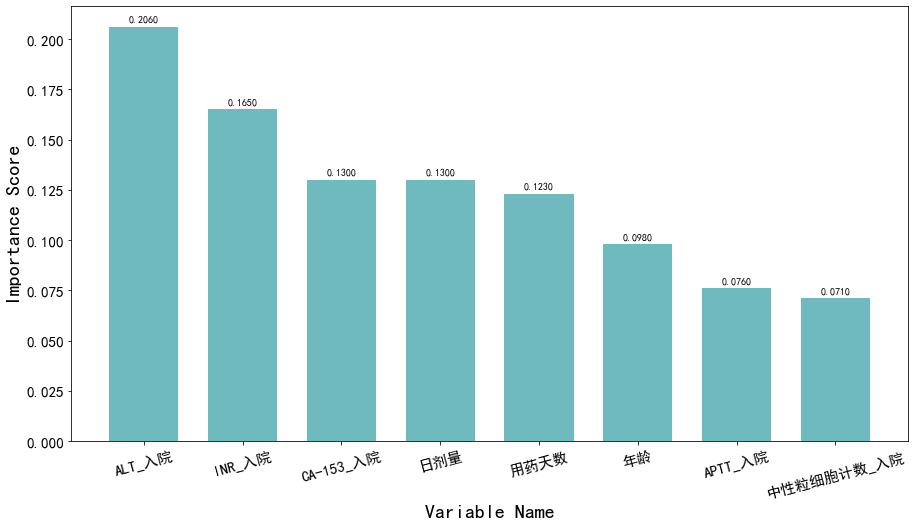

In [395]:
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']  ##绘图显示中文
mpl.rcParams['axes.unicode_minus'] = False

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import rc

names = df_importance['特征']
index = np.arange(len(names))
plt.figure(dpi=300)
plt.figure(figsize=(15, 8))
plt.bar(df_importance['特征'], df_importance['重要性评分'], width=0.7,
        color=(0.42941176470588235, 0.7294117647058823, 0.7490196078431373), tick_label=names)
# 设置坐标刻度值的大小
plt.tick_params(labelsize=15)
plt.xticks(rotation=15)

plt.ylabel('Importance Score',fontsize=20)
plt.xlabel('Variable Name',fontsize=20)
for a, b in zip(index, df_importance['重要性评分']):
    plt.text(a, b + 0.002, '%.4f' % b, ha='center', va='bottom', fontsize=10)
# plt.title('重要变量得分柱形图')
# plt.show()

### 散点图

In [51]:
# 判断文件路径是否存在，如果不存在则创建该路径
def mkdir(path):
    folder = os.path.exists(path)
    if not folder:  # 判断是否存在文件夹如果不存在则创建为文件夹
        os.makedirs(path)  # makedirs 创建文件时如果路径不存在会创建这个路径

In [ ]:
# 画图
print('-----------------------画图---------------------------')
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']  ##绘图显示中文
mpl.rcParams['axes.unicode_minus'] = False

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import rc
rc('mathtext', default='regular')

# 散点图
# axis设置坐标轴的范围
# plt.axis([-20, 20, 0, 200])
# x为x轴中坐标x的值，y为y轴中坐标y的值，x与y都是长度相同的数组序列，color为点的颜色，marker为散点的形状，
# 折线图刻度调小，要不然点都堆到一块了
ax = plt.gca()
ax.set_xlim(0,10)
ax.set_ylim(0,10)
# plt.scatter(range(len(test_y)),test_y,c='r')
plt.scatter(test_y,predictions,c='b')
# 红色参照线
plt.plot(list(range(test_y.shape[0])), list(range(test_y.shape[0])),color='r')
# plt.plot(list(range(30)), list(range(30)),color='r')
plt.xlabel('Number of Events(unit)')
plt.ylabel('MTX Bone Suppression')

In [52]:
# plt.show()
# 判断图片保存路径是否存在，否则创建
jpg_path = project_path + "/jpg"
mkdir(jpg_path)
plt.savefig(jpg_path + "/他克莫司血药浓度测试集散点图v2.0.jpg", dpi=300)
plt.clf()  # 删除前面所画的图

-----------------------画图---------------------------


<Figure size 432x288 with 0 Axes>

### AUC曲线

In [56]:
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']  ##绘图显示中文
mpl.rcParams['axes.unicode_minus'] = False

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import rc

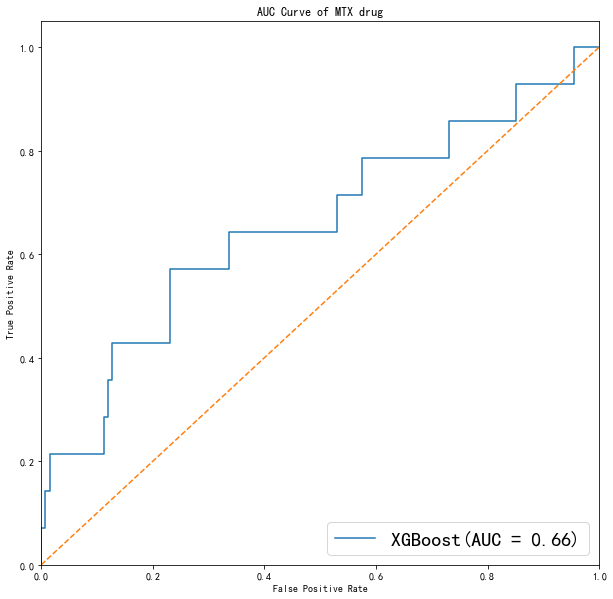

In [87]:
plt.figure(figsize=(10,10))

# plt.plot(logistic_fpr, logistic_tpr,label='LogisticRegression(AUC = %0.2f)' % logistic_auc) 
# plt.plot(rf_fpr, rf_tpr,label='RandomForest(AUC = %0.2f)' % rf_auc) 
plt.plot(xgb_fpr, xgb_tpr,label='XGBoost(AUC = %0.2f)' % xgb_auc) 
# plt.plot(ann_fpr, ann_tpr,label='ANN(AUC = %0.2f)' % ann_auc) 

plt.plot([0, 1], [0, 1],linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC Curve of MTX drug')
plt.legend(loc="lower right", fontsize=20)
plt.show()

### precision曲线

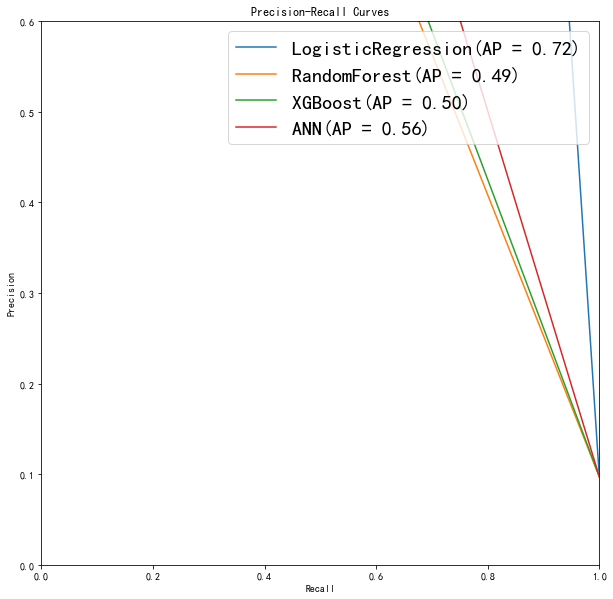

In [57]:
plt.figure(figsize=(10,10))

plt.plot(logistic_recall, logistic_precision, label='LogisticRegression(AP = %0.2f)' % logistic_ap)
plt.plot(rf_recall, rf_precision,label='RandomForest(AP = %0.2f)' % rf_ap) 
plt.plot(xgb_recall, xgb_precision,label='XGBoost(AP = %0.2f)' % xgb_ap) 
plt.plot(ann_recall, ann_precision,label='ANN(AP = %0.2f)' % ann_ap) 
         
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 0.6])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="upper right", fontsize=20)
plt.show()

### SHAP图

#### summary_plot

In [661]:
pd.value_counts(tran_y_sm)

0.0    108
1.0    108
Name: 日剂量, dtype: int64

In [358]:
tran_x_sm=tran_x.copy()
tran_y_sm=tran_y.copy()

In [359]:
# SHAP图
from pylab import mpl
from matplotlib import pyplot as plt
mpl.rcParams['font.sans-serif'] = ['SimHei']  ##绘图显示中文
mpl.rcParams['axes.unicode_minus'] = False
from matplotlib import rc
rc('mathtext', default='regular')

import catboost,xgboost
import shap
shap.initjs()  # notebook环境下，加载用于可视化的JS代码
# CatBoost模型
cat_model=xgboost.XGBClassifier(max_depth=5,
                        learning_rate=0.001,
                        n_estimators=500,
                        min_child_weight=0.5,
                        eta=0.1,
                        gamma=0.5,
                        reg_lambda=5,
                        subsample=0.8,
                        colsample_bytree=0.8,
                        nthread=4,
                        scale_pos_weight=1,
                        random_state=3)
cat_model.fit(tran_x_sm, tran_y_sm)

explainer = shap.TreeExplainer(cat_model)
shap_values = explainer.shap_values(tran_x_sm)  # 传入特征矩阵X，计算SHAP值
# print(shap_values)

In [298]:
tran_x_sm=tran_x_sm.rename(columns={'日剂量':'上一次日剂量',
                                   'gender':'性别',
                                   'age':'年龄',
                                   'test_result':'上一次TDM值'})

In [941]:
?shap.summary_plot

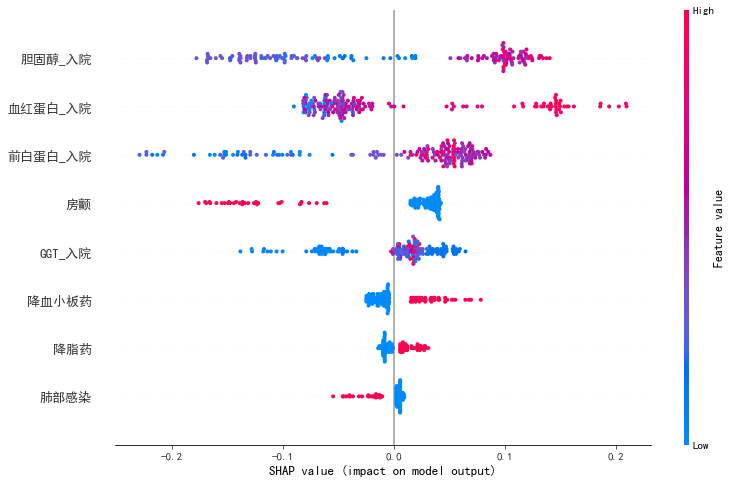

In [360]:
# summarize the effects of all the features
shap.summary_plot(shap_values, tran_x_sm,plot_size=(12,8),)
#                  class_names=['1mg','1.5mg','4mg','3mg','2.5mg','2mg'])

In [308]:
tran_x_sm.columns

Index(['体重', '钙离子阻抗剂', '上一次日剂量', '年龄', '糖尿病', '直接胆红素', '尿素', '淋巴细胞百分数', '高血压',
       '糖皮质激素', '性别', '上一次TDM值'],
      dtype='object')

In [320]:
type(shap_values)

list

In [666]:
df_shap_values

,0,1,2,3,4,5,6,label
0,3.333769,1.008152,0.988628,-0.071092,0.513993,-0.571060,-0.345089,1.0
1,-3.036667,0.556787,-0.042782,-0.244547,-1.502985,0.666590,-0.815771,0.0
2,-1.156161,1.305836,1.151194,0.457161,2.602305,-0.233718,-0.399447,1.0
3,-3.468739,-1.346333,-1.789265,-0.236250,-0.121771,-0.457438,-0.256855,0.0
4,6.506644,1.503949,-0.082385,0.171726,0.679662,1.065485,-0.120442,1.0
...,...,...,...,...,...,...,...,...
211,-3.600252,-1.580784,-0.314290,-0.153086,0.170325,0.124037,0.722369,0.0
212,-3.199505,0.303407,0.112323,-0.505899,-2.100364,-0.641356,-0.655191,0.0
213,-2.335317,-1.924601,-0.193261,-0.598222,0.712953,-0.463681,-0.873663,0.0
214,-3.077490,-0.876349,-0.247377,-0.402913,-1.704780,-0.386496,-0.755241,0.0


In [705]:
df_shap = pd.DataFrame(data={'features':shap_col,
                            'shap_pos':shap_pos_list,
                            'shap_neg':shap_neg_list})

In [706]:
df_shap

,features,shap_pos,shap_neg
0,VPA_TDM,82,134
1,P-LCR,123,93
2,PDW,116,100
3,Antipsychotic_drugs,98,118
4,Indirect_Bilirubin,131,85
5,PCV,94,122
6,Hb,65,151


In [708]:
df_shap.to_excel(project_path+'/data/result/df_shap.xlsx')

In [607]:
shap_list=[]
for i in range(df_shap_values.shape[1]-1):
    shap_value=df_shap_values.iloc[:,i].sum()
    shap_list.append(shap_value)
df_shap = pd.DataFrame(data={'features':tran_x_sm.columns,
                            'shap_value':shap_list})

In [609]:
df_shap_values.iloc[:,i]

0     -0.345089
1     -0.815771
2     -0.399447
3     -0.256855
4     -0.120442
         ...   
211    0.722369
212   -0.655191
213   -0.873663
214   -0.755241
215   -0.751668
Name: 6, Length: 216, dtype: float64

In [606]:
shap_list

[5.8572997963870295,
 -4.419375988914488,
 4.727170591923252,
 -7.676649352632006,
 10.724639449482003,
 8.021531210373883,
 8.82472834675256]

In [608]:
df_shap

,features,shap_value
0,test_result,-40.453473
1,大型血小板比值,36.070186
2,血小板分布宽度,-8.814643
3,血红蛋白测定,-0.772038
4,抗精神病药,12.686806
5,红细胞比积测定,1.033044
6,间接胆红素,0.250118


In [527]:
writer = pd.ExcelWriter(project_path + '/data/result/df_shap值排序.xlsx')
df_shap.to_excel(writer)
writer.save()

#### multioutput_decision_plot

In [942]:
?shap.multioutput_decision_plot

In [963]:
col=df_model.columns.to_list()
col.remove('label')

In [964]:
col

['体重',
 '钙离子阻抗剂',
 '日剂量',
 'age',
 '糖尿病',
 '直接胆红素',
 '尿素',
 '淋巴细胞百分数',
 '高血压',
 '糖皮质激素',
 'gender',
 'test_result']

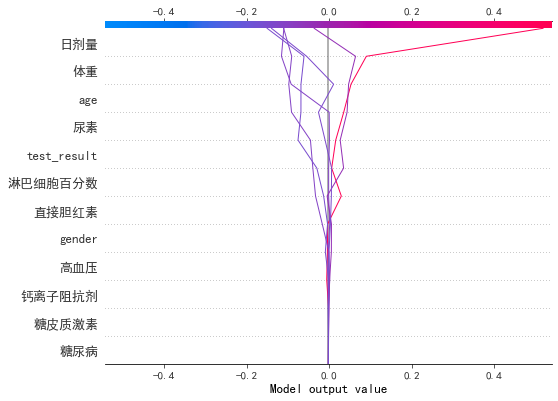

In [967]:
shap.multioutput_decision_plot(shap_values,shap_values,row_index=3,
                              feature_names=col)

In [935]:
shap_values

[array([[ 1.7884551e-02, -4.7067376e-03,  2.6966387e-01, ...,
         -1.2953198e-05,  5.6798651e-04, -3.8480440e-03],
        [-4.1816123e-02, -6.2801642e-03, -7.8413635e-02, ...,
         -2.7280410e-05, -1.8625727e-04, -8.1662061e-03],
        [ 3.9592050e-02,  9.0608848e-03,  2.9020017e-01, ...,
         -1.2953198e-05, -6.2250026e-04,  7.3326016e-03],
        ...,
        [ 2.5673578e-02, -1.4627557e-02, -6.8878576e-02, ...,
         -2.7280410e-05, -2.0426390e-04, -2.1328896e-02],
        [-4.1581895e-02,  1.0974685e-02, -7.5531624e-02, ...,
         -4.7779835e-05, -6.5903337e-04, -3.6281857e-03],
        [ 1.5059070e-02, -1.0826434e-02, -9.7172759e-02, ...,
         -4.7779835e-05,  8.0837111e-04, -7.6254238e-03]], dtype=float32),
 array([[ 0.0705109 ,  0.        ,  0.00364254, ..., -0.00032048,
          0.0028362 ,  0.00838457],
        [-0.04089006,  0.        , -0.08070022, ..., -0.00069359,
         -0.00989467, -0.00038218],
        [-0.01878903,  0.        ,  0.01004871

### 混淆矩阵图

In [323]:
from sklearn.metrics import classification_report,confusion_matrix
import catboost
# CatBoost模型
cat_model=xgboost.XGBClassifier(max_depth=5,
                        learning_rate=0.001,
                        n_estimators=500,
                        min_child_weight=0.5,
                        eta=0.1,
                        gamma=0.5,
                        reg_lambda=5,
                        subsample=0.8,
                        colsample_bytree=0.8,
                        nthread=4,
                        scale_pos_weight=1,
                        random_state=3)

cat_model.fit(tran_x_sm,tran_y_sm)
cat_predictions=cat_model.predict(test_x)
# 计算混淆矩阵
cat_confusion=confusion_matrix(test_y,cat_predictions)

In [324]:
cat_confusion

array([[4, 0, 0, 0, 0, 0],
       [1, 4, 0, 0, 0, 0],
       [1, 0, 5, 0, 0, 0],
       [0, 0, 0, 2, 0, 0],
       [0, 0, 0, 0, 4, 0],
       [0, 0, 1, 0, 0, 3]], dtype=int64)

0 0
0 1
0 2
0 3
0 4
0 5
1 0
1 1
1 2
1 3
1 4
1 5
2 0
2 1
2 2
2 3
2 4
2 5
3 0
3 1
3 2
3 3
3 4
3 5
4 0
4 1
4 2
4 3
4 4
4 5
5 0
5 1
5 2
5 3
5 4
5 5


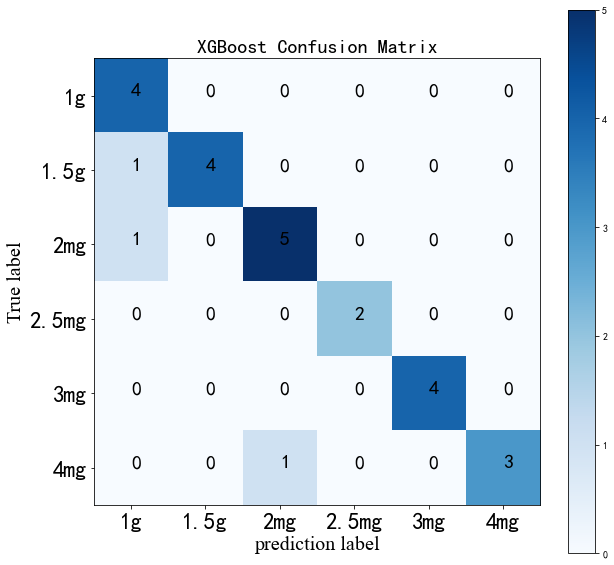

In [330]:
plt.figure(figsize=(10,10))
plt.imshow(cat_confusion, cmap=plt.cm.Blues) # 在特定的窗口上显示图像
# 设置图表标题
plt.title('XGBoost Confusion Matrix',size=20)    # 图像标题
plt.colorbar()
# 设置坐标轴标题
font_x = {'family': 'Times New Roman',
         'weight': 'normal',
         'size': 20,}
plt.xlabel('prediction label',font_x)
plt.ylabel('True label',font_x)
# 设置坐标轴刻度
plt.tick_params(labelsize=23)  # 设置刻度值大小
label_names=['1g','1.5g','2mg','2.5mg','3mg','4mg']
plt.xticks(range(len(label_names)),label_names)
plt.yticks(range(len(label_names)),label_names)
# 显示数据
for first_index in range(len(cat_confusion)):    #第几行
    for second_index in range(len(cat_confusion[first_index])):    #第几列
        print(first_index, second_index)
        plt.text(second_index,first_index, cat_confusion[first_index][second_index],size=20)
plt.show()

In [471]:
cat_confusion

array([[27,  0],
       [ 1,  5]], dtype=int64)

In [475]:
for first_index in range(len(cat_confusion)):    #第几行
    print(cat_confusion[first_index])
    break

[27  0]


In [476]:
for second_index in range(len(cat_confusion[first_index])):    #第几列
    print(cat_confusion[first_index][second_index])

27
0


0 0
27
0 1
0
1 0
1
1 1
5


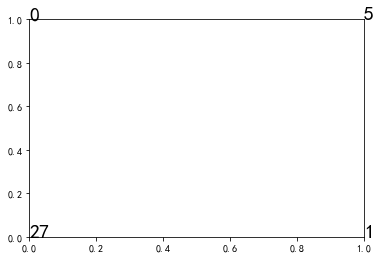

In [480]:
# 显示数据
for first_index in range(len(cat_confusion)):    #第几行
    for second_index in range(len(cat_confusion[first_index])):    #第几列
        print(first_index, second_index)
        print(cat_confusion[first_index][second_index])
        plt.text(first_index, second_index, cat_confusion[first_index][second_index],size=20)
plt.show()

### tabnet mask graph

In [299]:
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
TabNet_model = TabNetClassifier()  #TabNetRegressor()
tran_x_x, tran_x_valid, tran_y_y, tran_y_valid = train_test_split(tran_x_sm, tran_y_sm, test_size=0.1, random_state=3)

TabNet_model.fit(X_train=tran_x_x.to_numpy(),  
        y_train=tran_y_y.to_numpy(), 
        eval_set=[(tran_x_valid.to_numpy(), tran_y_valid.to_numpy())], 
        eval_name=['train'], 
        eval_metric=['auc'],
        max_epochs=100,
        patience=15,
        batch_size=128,
        virtual_batch_size=15,
        num_workers=0,
        drop_last=False)

Device used : cpu
epoch 0  | loss: 0.75528 | train_auc: 0.63881 |  0:00:00s
epoch 1  | loss: 0.59836 | train_auc: 0.92063 |  0:00:00s
epoch 2  | loss: 0.56821 | train_auc: 0.91119 |  0:00:00s
epoch 3  | loss: 0.50365 | train_auc: 0.96853 |  0:00:01s
epoch 4  | loss: 0.45512 | train_auc: 0.94126 |  0:00:01s
epoch 5  | loss: 0.41852 | train_auc: 0.92727 |  0:00:01s
epoch 6  | loss: 0.43255 | train_auc: 0.94441 |  0:00:01s
epoch 7  | loss: 0.40222 | train_auc: 0.94545 |  0:00:02s
epoch 8  | loss: 0.36702 | train_auc: 0.91993 |  0:00:02s
epoch 9  | loss: 0.35444 | train_auc: 0.96294 |  0:00:02s
epoch 10 | loss: 0.36125 | train_auc: 0.97343 |  0:00:02s
epoch 11 | loss: 0.3187  | train_auc: 0.97203 |  0:00:02s
epoch 12 | loss: 0.28125 | train_auc: 0.97098 |  0:00:03s
epoch 13 | loss: 0.2984  | train_auc: 0.98427 |  0:00:03s
epoch 14 | loss: 0.27376 | train_auc: 0.98147 |  0:00:03s
epoch 15 | loss: 0.23633 | train_auc: 0.97028 |  0:00:03s
epoch 16 | loss: 0.24844 | train_auc: 0.97063 |  0:00:

In [211]:
explain_matrix,masks=TabNet_model.explain(tran_x_sm.to_numpy())

AttributeError: 'CatBoostClassifier' object has no attribute 'explain'

NameError: name 'explain_matrix' is not defined

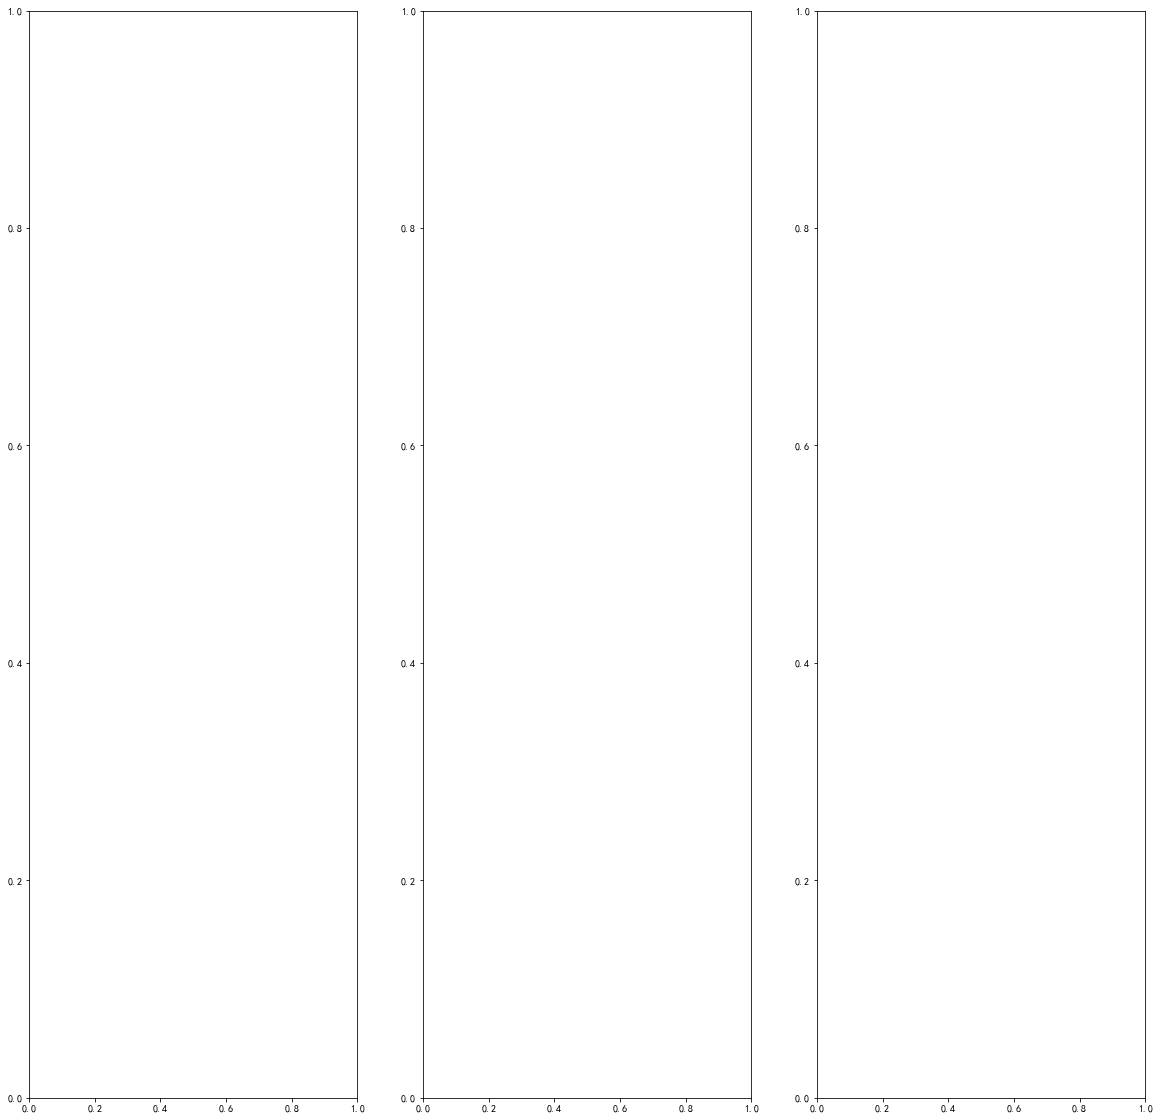

In [212]:
from matplotlib import pyplot as plt
# fig = plt.figure(figsize=(40,40))
# ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
# plt.yticks(np.arange(0, len(explain_matrix), 1.0))
# plt.xticks(np.arange(0, len(explain_matrix[0]), 1.0))
# ax.set_xticklabels(tran_x_sm.columns, rotation=75)
# plt.ylabel('Sample Number')
# plt.xlabel('Variable')
# # plt.imshow(explain_matrix[:30])  # 显示30个

fig, axs = plt.subplots(1, 3, figsize=(20,20))
for i in range(3):
    axs[i].set_yticks(np.arange(0, len(explain_matrix), 1.0))  # 设置左边间距
    axs[i].set_xticks(np.arange(0, len(explain_matrix[0]), 2.0))
    axs[i].set_ylabel('Sample Number',size=20)
    axs[i].set_xlabel('Variable',size=20)
    # 设置坐标刻度值的大小
    axs[i].tick_params(labelsize=15)
    axs[i].imshow(masks[i][:30])
    axs[i].set_title(f"mask {i}")
    axs[i].set_xticklabels(tran_x_sm.columns[::2], rotation=90)

In [351]:
tran_x_sm.columns

Index(['单核细胞绝对值', '异甘草酸镁', '谷草转氨酶(干式)', '甘草酸苷', '单核细胞百分比', '淋巴细胞百分比',
       '乳酸脱氢酶(干式)', '托烷司琼', '中性细胞绝对值', '嗜酸性细胞绝对值', '谷胱甘肽', '红细胞', '嗜酸性细胞百分比',
       '多烯磷脂酰', '嗜碱性细胞百分比', 'age', 'gender', 'RBC平均容量', 'MTX_tdm_72h',
       '白蛋白(干式)', '中性细胞百分比', 'MTX_tdm_48h', '总蛋白(干式)', '淋巴细胞绝对值', '吸烟史',
       '肌酐(干式)', 'MTX_tdm_24h', '日剂量', '长春新碱', 'RBC血红浓度'],
      dtype='object')